<a href="https://colab.research.google.com/github/CoDeRror555/Analytic_projects-/blob/main/wiki_vote_analytic/wiki_voted_analytic_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследовательский анализ пользователей Wikipedia, особенности их электорального поведения

# Основные цели:
* **Выявить закономерности и особенности активности пользователей**
* **Провести сегментацию пользователей**
* **Провести анализ электорального поведения во время выборов**
 ## Решённые задачи:
 - [x] **Проведена предобработка данных**
 - [x] **Выявлены особенности активности пользователей**
 - [x] **Введены новые метрики описывающие пользователей**
 - [x] **Составлен профиль пользователя**
 - [x] **Проведена сегментация пользователей**
 - [x] **Проведен анализ электорального поведения во время выборов**
 - [x] **Определена взаимосвязь между активностью пользователей и моделью их электорального поведения**
 - [x] **Определены аномалии во время выборов**
 - [x] **Определен круг пользователей, проявивших аномальное электоральное поведение**
### Используемые инструменты:
   * *python, numpy, pandas, matplotlib, seaborn, sklearn*
* **

In [99]:
# запросы в интернет
import urllib
import requests

# работа с таблицами
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# кластеризация 
from sklearn.cluster import KMeans
# статистика
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [100]:
# загрузим данные
# global case case
df_votes = pd.read_excel('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/i/IryUuAFFYlc57w',index_col=0)
df_users = pd.read_excel('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/i/eS3FvUuLlBawtg',index_col=0)

In [101]:
# функция для получения иныфо о данных
def df_info(df:pd.DataFrame) -> None:
    '''Распечатывает информацию о датафрейме'''
    print(f"Количество полных дубликатов: {df.duplicated().sum()}")
    print('****************')
    
    # Выводим инфо
    df.info()
    

    # Сохраняем пропуски
    df_nans = np.trim_zeros(df_users.isna().mean().sort_values())

    if len(df_nans > 0):
        print('\nNA:',end='')
        display(df_nans)
    
    # Пример данных
    display(df.dropna().sample().T)

    for col in df.columns:
        if df[col].nunique() < 20:
            display(df[col].value_counts())

# Предобработка и анализ таблицы с данными об активности пользователей

In [102]:
# отобразим основную информацию
df_info(df_users)

Количество полных дубликатов: 0
****************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2828 entries, 0 to 2827
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User               2828 non-null   object
 1   Groups             73 non-null     object
 2   EditsTotal         2828 non-null   int64 
 3   EditsEdits         2828 non-null   int64 
 4   EditsArticles      2828 non-null   int64 
 5   CreationsPages     2828 non-null   int64 
 6   CreationsArticles  2828 non-null   int64 
 7   TextsVolume        2828 non-null   int64 
 8   Logs               2828 non-null   int64 
 9   Months             2828 non-null   int64 
 10  H/d                2828 non-null   object
dtypes: int64(8), object(3)
memory usage: 265.1+ KB

NA:

Groups    0.974187
dtype: float64

1472
User               Rampion
Groups                   S
EditsTotal           10673
EditsEdits            6686
EditsArticles         3161
CreationsPages         314
CreationsArticles       26
TextsVolume        3400000
Logs                  3987
Months                 116
H/d                   25 m

S      60
BS      4
COS     3
IS      2
I       2
OS      1
BOS     1
Name: Groups, dtype: int64

* **Мы видим проблемы с названиями колонок, большое количество пропусков в колонке с группами, неверный формат в колонке со средним временем у юзера. Добавим функции для корректировок**

In [103]:
# добавляет аннотации к барам
def add_value_labels(ax,bar_or_barh, space=4,fmt="{:.0f}"):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
        frm: format annotaitions
        bar_or_barh: chose bar or barh pyplot
    """
    if bar_or_barh == 'bar':
        # For each bar: Place a label
        heights = [rect.get_height() for rect in ax.patches]
        for rect in ax.patches:
            # Get X and Y placement of label from rect.
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2
            
            
            if y_value > 0:
                va = 'bottom'
                label = fmt.format(y_value)
                # Create annotation
                if y_value > max(heights)/2:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, y_value/2),         # Place label at end of the bar
                        xytext=(0, space),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)                      # Vertically align label differently for
                else:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, rect.get_y()+rect.get_height()),         # Place label at end of the bar
                        xytext=(0, space),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,size = 10)
            elif y_value == 0:
                va = 'top'
                label = fmt.format(y_value)
                ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, rect.get_y()+rect.get_height()),         # Place label at end of the bar
                        xytext=(0, space),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va='center',
                        rotation=90,size = 10)
                
            else:
            
                # Invert space to place label belo
                # Vertically align label at top
                va = 'top'
                # Use Y value as label and format number with one decimal place
                label = fmt.format(y_value)
                    # Create annotation
                if y_value < min(heights)/2:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, y_value/2),         # Place label at end of the bar
                        xytext=(0, 0),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)                      # Vertically align label differently for
                                                    # positive and negative values.
                else:
                    ax.annotate(
                        label,                      # Use `label` as label
                        (x_value, rect.get_y()+rect.get_height()),         # Place label at end of the bar
                        xytext=(0, 0),          # Vertically shift label by `space`
                        textcoords="offset points", # Interpret `xytext` as offset in points
                        ha='center',                # Horizontally center label
                        va=va,
                        rotation=90,size = 10)                      # Vertically align label differently for
                                                # positive and negative values.
    elif bar_or_barh == 'barh':
        
        # Получаем ширины столбиков
        widths = [rect.get_width() for rect in ax.patches]
        heights = [rect.get_height() for rect in ax.patches]
        # Добавляем аннотации на каждый столбик     
        for i, rect in enumerate(ax.patches):
            # Перемещаем аннотацию внутрь столбика         
            if widths[i] < 0:
                if widths[i] < min(widths)/2:
                    space *= -1
                    ax.annotate(fmt.format(widths[i]), xy=(widths[i]/2, rect.get_y() + rect.get_height()/2),\
                                xytext=(0, 0), textcoords="offset points", ha='center', va='center',color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)
                else:
                    space *= -1
                    ax.annotate(fmt.format(widths[i]), xy=(rect.get_x() + rect.get_width(),rect.get_y() + rect.get_height() / 2),\
                            xytext=(space-3, 0), textcoords="offset points", ha='right', va='center',size = 10)
            
            elif widths[i] == 0:
                ax.annotate(fmt.format(widths[i]), xy=(widths[i],rect.get_y() + rect.get_height()/2),\
                            xytext=(0, 0), textcoords="offset points", ha='center', va='center',size = 10)
                
            elif widths[i] > 0:
                if widths[i] > max(widths)/2:
                    ax.annotate(fmt.format(widths[i]), xy=(widths[i]/2, rect.get_y() + rect.get_height()/2),\
                                xytext=(0, 0), textcoords="offset points", ha='center', va='center',color='black',bbox = dict(boxstyle="round", fc="w", ec="0.99", alpha=0.7),size = 10)

                else:
                    ax.annotate(fmt.format(widths[i]), xy=(rect.get_x() + rect.get_width(),rect.get_y() + rect.get_height() / 2),\
                            xytext=(space, 0), textcoords="offset points", ha='left', va='center',size = 10)
    else:
        return(print("inter name 'bar or bash'"))

In [104]:
# понижает регистр
def corrected_columns(list_col):
    try:
        columns = []
        for i in list_col:
            columns.append(i.lower().strip().replace(' ','_'))
        return(columns)
    except: print('err')


In [105]:
# переводит строковый формат в количество минут для нашего случая
def hour_to_minute(s):
    try:
        if ' h' in s:
            s1 = s.split(' h')
            if s1[1] == '':
                t1= int(s1[0])*60
                return t1
            else:
                t1 = (int(s1[0])*60)+int(s1[1])
                return t1
        elif ' m' in s:
                s2 = s.split(' m')
                return int(s2[0])
        else:
            return int(s)
    except: return s


In [106]:
# проводит сегментацию по квартилям, названия сегментов соответствуют можквартильноиу промежутку

def four_value_quant_seg(df,s, q_grup=4):

  groups = range(q_grup)
  for i in s:
    name_s = i + '_seg'
    df[name_s] = pd.qcut(df[i], q=q_grup, labels=groups, precision=0)
  return df


In [107]:
# приведем названия в порядок
df_users.columns = corrected_columns(df_users.columns)

In [108]:
# исправим параметры активности
df_users['min/day'] = df_users['h/d'].apply(hour_to_minute)

In [109]:
# проверим
df_users.head()

user groups  editstotal  editsedits  editsarticles  \
0  MarchHare1977    NaN      670625      658747         229189   
1    Q-bit array    COS      568443      278128         119067   
2       Valdis72    NaN      461773      268027         226018   
3         Tempus    NaN      372796      339636         269363   
4        Simba16    NaN      370125      333356         277881   

   creationspages  creationsarticles  textsvolume    logs  months     h/d  \
0          423066              18263     79000000   11878      49  8 h 15   
1           62470                 40    203000000  290315     103  4 h 25   
2           36916              12295    116000000  193746     124  6 h 50   
3           29679                922    141000000   33160     173  3 h 40   
4           29413               5020     67000000   36769     135  3 h 05   

   min/day  
0      495  
1      265  
2      410  
3      220  
4      185

In [110]:
print(f'Всего пользователей: {len(df_users.user.unique())}')
print(f"Пользователей с расширенным правами: {len(df_users.loc[~df_users['groups'].isna()])}")

Всего пользователей: 2828
Пользователей с расширенным правами: 73


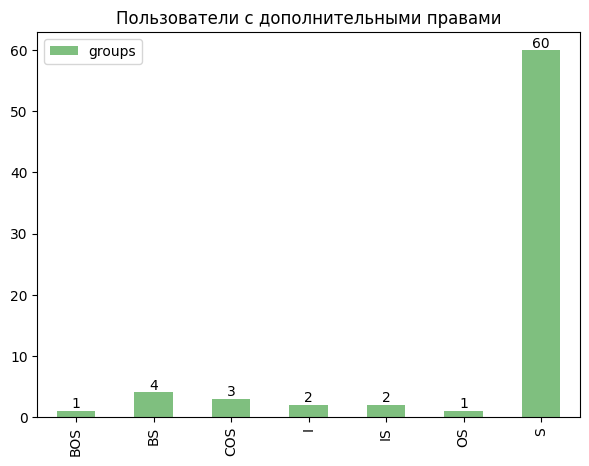

In [111]:
# посмотрим на пользователей с дополнительными правами
ax = df_users.groupby(by='groups')['groups'].count().plot(kind ='bar', color = 'green', alpha=0.5,figsize=(7,5))
#add_value_labels(ax,'bar', space=4,fmt="{:.0f}")
for i, v in enumerate(df_users.groupby(by='groups')['editstotal'].count()):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.title('Пользователи с дополнительными правами')
plt.ylabel('')
plt.xlabel('')
plt.legend()
plt.show()

* **Менее 2 процентов из представленных пользователей имеют расширенные права, причем основная их часть это администраторы. Всего таких пользователей: 73**

## Разберем столбцы  'editstotal', 'editsedits', 'editsarticles'

*Очевидно что данные поля содержат подобную информацию о пользователе, которая может пересекаться и имееть сильную корреляцию. Построим парный график*

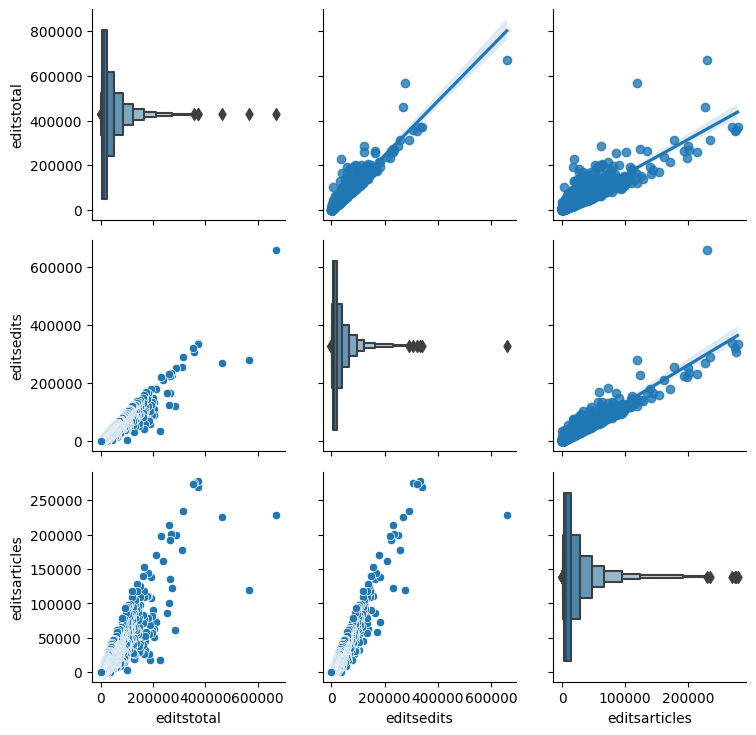

editstotal  editsedits  editsarticles
editstotal       1.000000    0.956543       0.892058
editsedits       0.956543    1.000000       0.945532
editsarticles    0.892058    0.945532       1.000000

editstotal


count      2828.00
mean      25260.69
std       41604.76
min           1.00
25%        6389.75
50%       11238.50
75%       24941.25
max      670625.00
Name: editstotal, dtype: float64

****************************
editsedits


count      2828.00
mean      20305.71
std       32712.98
min           0.00
25%        5687.25
50%        9608.00
75%       20983.50
max      658747.00
Name: editsedits, dtype: float64

****************************
editsarticles


count      2828.00
mean      14264.88
std       23723.76
min           0.00
25%        3767.25
50%        6478.50
75%       14360.75
max      277881.00
Name: editsarticles, dtype: float64

****************************


In [112]:
# посмотрим на распределения в данных полях
g = sns.PairGrid(df_users[['editstotal','editsedits','editsarticles']], height=2.5)
g.map_upper(sns.regplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.boxenplot)
plt.show();
display(df_users[['editstotal','editsedits','editsarticles']].corr())
# посмотрим на значения
for i in df_users[['editstotal','editsedits','editsarticles']].columns:
    print(i)
    display(df_users[i].describe(include='all').round(2))
    print('****************************')

* **Как и ожидалось, значения в данных полях имеют тенденцию на уменьшение значений от первого к последнему полю и очень сильно коррелируют. Логично предположить, что это подобные множества и описывать пользователя не целесообразно по всем 3 отдельно. Так же можно обратить внимание на сильное одностароннее смещение значеней и большие выбросы**

## Разберем поля 'creationsarticles' и 'creationspages'

<Figure size 1500x1500 with 0 Axes>

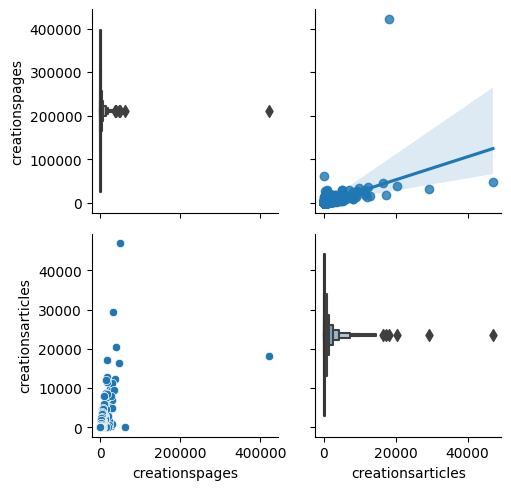

creationspages  creationsarticles
creationspages           1.000000           0.482074
creationsarticles        0.482074           1.000000

******************************
creationspages


count      2828.00
mean       1608.50
std        8682.66
min           0.00
25%         156.00
50%         471.00
75%        1316.50
max      423066.00
Name: creationspages, dtype: float64

****************************
creationsarticles


count     2828.00
mean       445.89
std       1582.15
min          0.00
25%         29.00
50%        103.00
75%        329.00
max      47062.00
Name: creationsarticles, dtype: float64

****************************


In [113]:
# посмотрим на распределения в данных полях
plt.figure(figsize=(15,15))
g = sns.PairGrid(df_users[['creationspages',	'creationsarticles']],height=2.5)
g.map_upper(sns.regplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.boxenplot)
plt.show()
display(df_users[['creationspages',	'creationsarticles']].corr())
print('******************************')
# посмотрим на значения
for i in df_users[['creationspages',	'creationsarticles']].columns:
    print(i)
    display(df_users[i].describe([.25, .5, .75],include='all').round(2))
    print('****************************')

* **По данным полям мы видим что уровень корреляции не столь значительный, но давольно существенный. Средние медианные значения составляют 103 и 471 соответственно.**

## Разберем столбцы 'min/day', 'months', 'textsvolume' и 'logs'

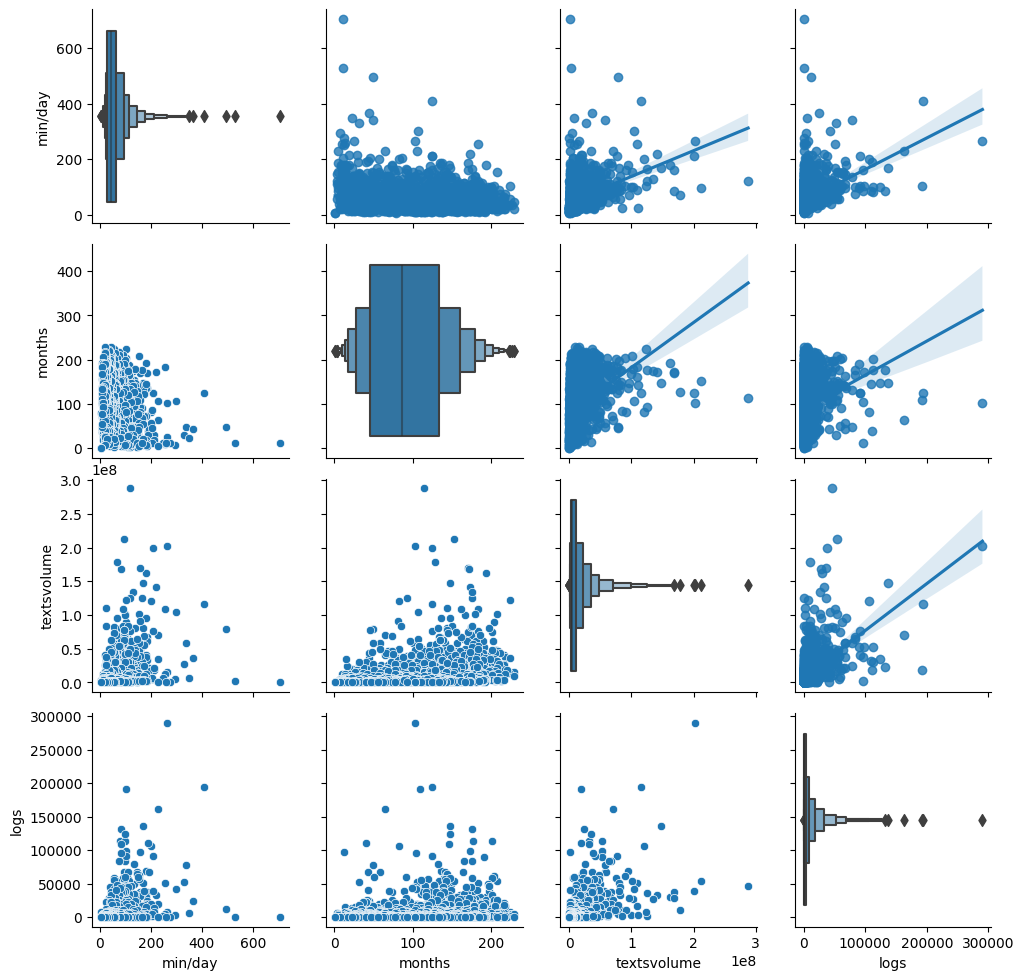

min/day    months  textsvolume      logs
min/day      1.000000 -0.182226     0.404314  0.381980
months      -0.182226  1.000000     0.346917  0.203123
textsvolume  0.404314  0.346917     1.000000  0.537439
logs         0.381980  0.203123     0.537439  1.000000

******************************
min/day


count    2828.00
mean       55.18
std        41.76
min         5.00
25%        30.00
50%        45.00
75%        65.00
max       705.00
Name: min/day, dtype: float64

****************************
months


count    2828.00
mean       91.86
std        53.26
min         1.00
25%        46.00
50%        86.00
75%       134.00
max       229.00
Name: months, dtype: float64

****************************
textsvolume


count    2.828000e+03
mean     1.075621e+07
std      1.820442e+07
min      0.000000e+00
25%      2.300000e+06
50%      4.900000e+06
75%      1.100000e+07
max      2.880000e+08
Name: textsvolume, dtype: float64

****************************
logs


count      2828.00
mean       4955.04
std       14048.32
min           0.00
25%         251.25
50%        1011.00
75%        3642.75
max      290315.00
Name: logs, dtype: float64

****************************


In [114]:
# посмотрим на распределения в данных полях
g = sns.PairGrid(df_users[['min/day','months','textsvolume','logs']], height=2.5)
g.map_upper(sns.regplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.boxenplot)
plt.show();
display(df_users[['min/day','months','textsvolume','logs']].corr())
print('******************************')
# посмотрим на значения
for i in df_users[['min/day','months','textsvolume','logs']].columns:
    print(i)
    display(df_users[i].describe([.25, .5, .75],include='all').round(2))
    print('****************************')

* **Мы видим увеличение добавленного текста и числа логов с увеличением срока жизни пользователя и среднего количества потраченного времени. Также можно заметить небольшое снижение среднего времени в сети с увеличением срока жизни пользователя. Средние медианное значение для полей 'min/day','months','textsvolume' и logs равно 45 минут, 86 месяцев, 4.90000000000 байт и 1011 записей в логах соответственно. В полях не отражающих временные показатели значения имеют ассиметричное распределение значений с сильными выбросами в большую сторону**

## Обоснование введения новых метрик

**На основе проведенного анализа данных мы можем сделать вывод, что для более точного описания активности пользователя нам будет целесообразно ввести новые показатели, которые свяжут поля с сильной корреляцией и логической ее связью между собой. Далее, для более точной сегментации наших пользователей, ввиду будущего наличия у них качественных поведенческих признаков, для количественных параметров мы выберем принцип сегментации по квартилям, которое будет делить наше множество на равные группы на основе межквартельного пространства этого параметра, таким образом мы уровняем вес этих показателей, чтобы в дальнейшем провести кластерный анализ по этим показателям**


 ### Введем новые параметры product_month, txv_month, ef_edit, is_artictl

**'txv_month' - количество добавленного текста в несяц**

In [115]:
df_users['txv_month'] = (df_users['textsvolume']/df_users['months'])/1048576

**'product_month' - продуктивность отражает кольчество сделланного продукта(в нашем случае под продуктом имеется ввиду правка, страница либо статья) в месяц**

In [116]:
df_users['product_month'] =  (df_users['editstotal']+df_users['creationspages']+df_users['creationsarticles'])/df_users['months']

**'ef_edit' - эффективность отражает отношение принятых ко всем правкам**

In [117]:
df_users['ef_edit'] = df_users['editsedits']/df_users['editstotal']

**'is_artictl' - отражает разность между общей и энциклопедической активностью**

In [118]:
df_users['is_artictl'] = (df_users['editsedits'] + df_users['creationspages'])\
                          -(df_users['editsarticles'] + df_users['creationsarticles'])

## Проведем анализ взаимосвязей новых метрик

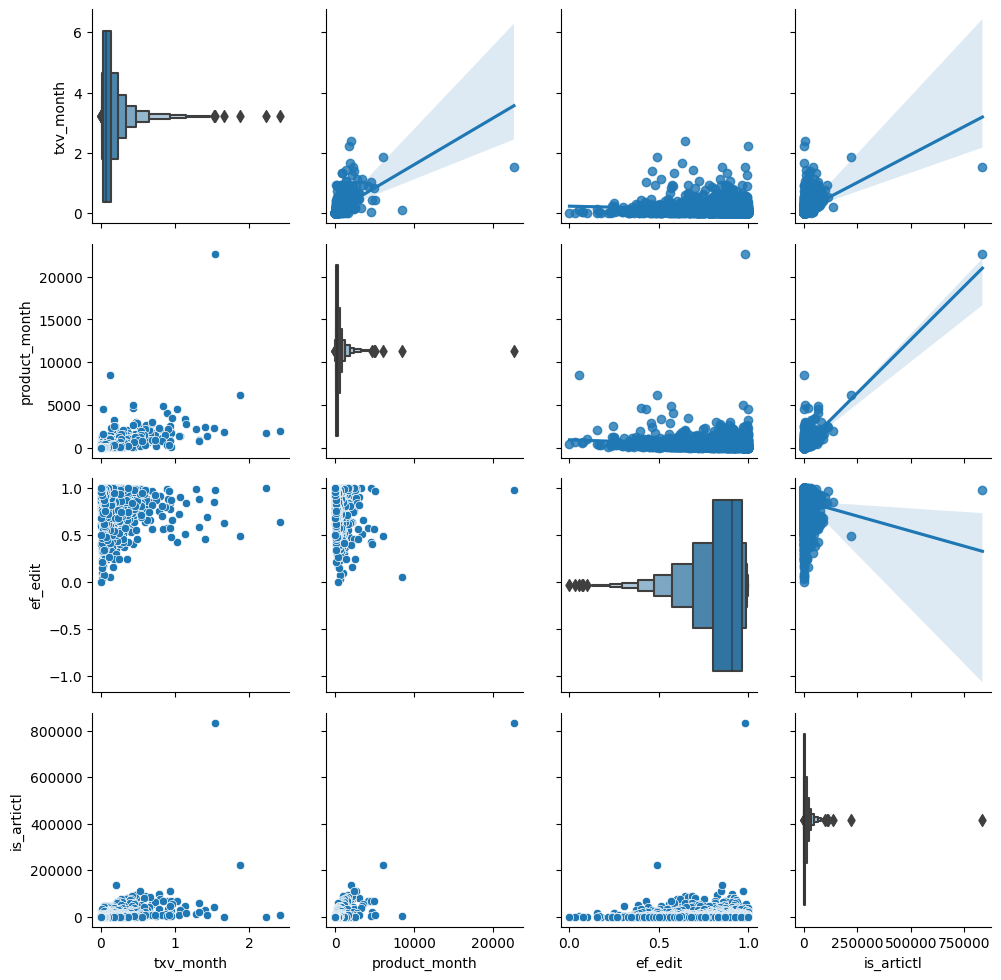

txv_month  product_month   ef_edit  is_artictl
txv_month       1.000000       0.581695 -0.124882    0.442519
product_month   0.581695       1.000000 -0.170632    0.788793
ef_edit        -0.124882      -0.170632  1.000000   -0.084056
is_artictl      0.442519       0.788793 -0.084056    1.000000

******************************
txv_month


count    2828.0000
mean        0.1175
std         0.1657
min         0.0000
25%         0.0319
50%         0.0669
75%         0.1402
max         2.4093
Name: txv_month, dtype: float64

****************************
product_month


count     2828.0000
mean       324.6768
std        624.9828
min          1.0000
25%         94.8962
50%        177.4831
75%        357.5604
max      22692.9388
Name: product_month, dtype: float64

****************************
ef_edit


count    2828.0000
mean        0.8585
std         0.1507
min         0.0000
25%         0.8005
50%         0.9091
75%         0.9675
max         1.0000
Name: ef_edit, dtype: float64

****************************
is_artictl


count      2828.0000
mean       7203.4268
std       19724.2131
min           0.0000
25%        1272.7500
50%        3019.0000
75%        7167.5000
max      834361.0000
Name: is_artictl, dtype: float64

****************************


In [119]:
# посмотрим на распределения в данных полях
g = sns.PairGrid(df_users[['txv_month',	'product_month',	'ef_edit',	'is_artictl']], height=2.5)
g.map_upper(sns.regplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.boxenplot)
plt.show();
display(df_users[['txv_month',	'product_month',	'ef_edit',	'is_artictl']].corr())
print('******************************')
# посмотрим на значения
for i in df_users[['txv_month',	'product_month',	'ef_edit',	'is_artictl']].columns:
    print(i)
    display(df_users[i].describe([.25, .5, .75],include='all').round(4))
    print('****************************')

* **Экстремальных корреляций не видно, однако стоит заметить слабую отрицательную связь эффективности со всеми параметрами. Так же мы видим довольно сильную положительную связь между продуктивностью и активностью в энциклопедическом направлении, что можно объяснить методикой подсчета этих показателей**

# Вывод по итогам предобработки и анализа показателей  активности пользователей:
* ****
* **Менее 2 процентов из представленных пользователей имеют расширенные права, причем основная их часть это администраторы. Всего таких пользователей: 73**
* **Мы видим увеличение добавленного текста и числа логов с увеличением срока жизни пользователя и среднего количества потраченного времени. Также можно заметить небольшое снижение среднего времени в сети с увеличением срока жизни пользователя.**
* **Стоит заметить слабую отрицательную связь эффективности со всеми параметрами. Так же мы видим довольно сильную положительную связь между продуктивностью и активностью в энциклопедическом направлении**
* **Довольно высокий показатель отрицательной корреляции между эффективностью правик и количеством логов**
* **Незначительное снижение среднего потраченного времени с увеличением срока жизни юзера**
* **Во всех полях с количественными значениями значения распределены неравномерно и имеют большие выбросы**

# Сегментация пользователей по межквартальным пространствам их показателей активности

* **Сегментацию проведем по следующим показателям: 'logs', 'months',    'min/day',  'txv_month',    'product_month',    'ef_edit',  'is_artictl','editsarticles','creationsarticles'. Которые должны максимально полно описать каждого пользователя. Для начала проверим уровень корреляции в них**

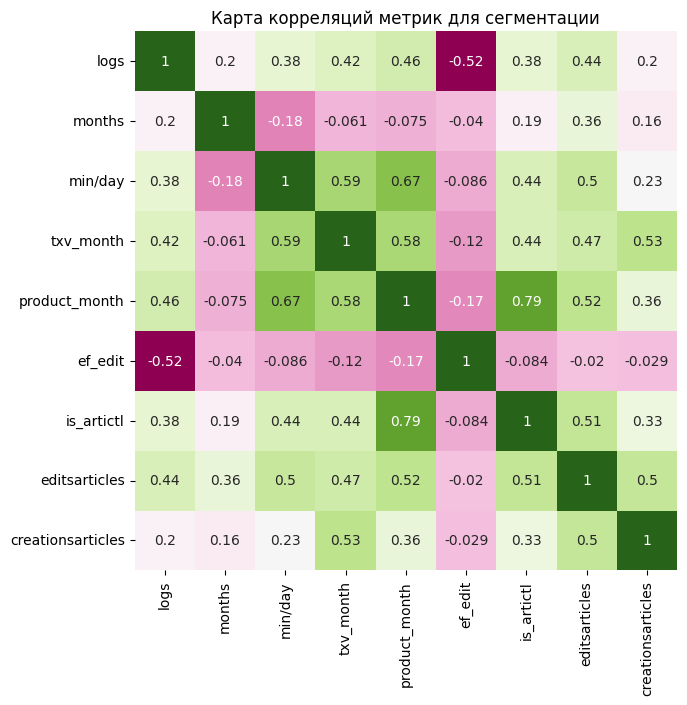

In [120]:
# построим тепловую карту корреляций 
plt.figure(figsize=(7,7))
sns.heatmap(df_users[['logs', 'months',	'min/day',	'txv_month',	'product_month',	'ef_edit',	'is_artictl','editsarticles','creationsarticles']].corr(),annot=True,cbar=False,cmap="PiYG")
plt.title('Карта корреляций метрик для сегментации')
plt.show()

* **Экстремальных уровней корреляции не видно, но мы можем заметить небольшую отрицательную связь эффекривности правок ко всем параметрам и особо сильный ее уровень с количеством логов**

* **Применем функцию проведем сегментацию на 5 равных частей, каждой части дадим численное значение от 0 до 4, где 0 будут принадлежать минимальные значения  а 4 максимальные**

In [121]:
# применем функцию и проведем сегментацию на 5 равных частей
vote_prof = four_value_quant_seg(df_users,s=['logs', 'months', 'min/day', 'txv_month', 'product_month', 'ef_edit', 'is_artictl','editsarticles','creationsarticles'],q_grup=5)

In [122]:
# выделим профили
vote_prof = vote_prof[['user','logs_seg',   'months_seg',   'min/day_seg',  'txv_month_seg',    'product_month_seg',    'ef_edit_seg',  'is_artictl_seg','editsarticles_seg','creationsarticles_seg']]
vote_prof.index = vote_prof.user
vote_prof = vote_prof.drop('user', axis=1).astype('int8').copy()
vote_prof.head()

logs_seg  months_seg  min/day_seg  txv_month_seg  \
user                                                              
MarchHare1977         4           1            4              4   
Q-bit array           4           2            4              4   
Valdis72              4           3            4              4   
Tempus                4           4            4              4   
Simba16               4           3            4              4   

               product_month_seg  ef_edit_seg  is_artictl_seg  \
user                                                            
MarchHare1977                  4            4               4   
Q-bit array                    4            0               4   
Valdis72                       4            0               4   
Tempus                         4            2               4   
Simba16                        4            2               4   

               editsarticles_seg  creationsarticles_seg  
user                                                     
MarchHare1977                  4                      4  
Q-bit array                    4                      1  
Valdis72                       4                      4  
Tempus                         4                      4  
Simba16                        4                      4

* **Среднее значение выбранных показателей активности будет выражено дробным числом от 0 до 4, которое даст описательньное значение для каждого пользователя, назавем его качественным значением активности(более качественный не обязятельно значит что лучше или хуже). Посмотрим на распределение этих значений в общей выборке**

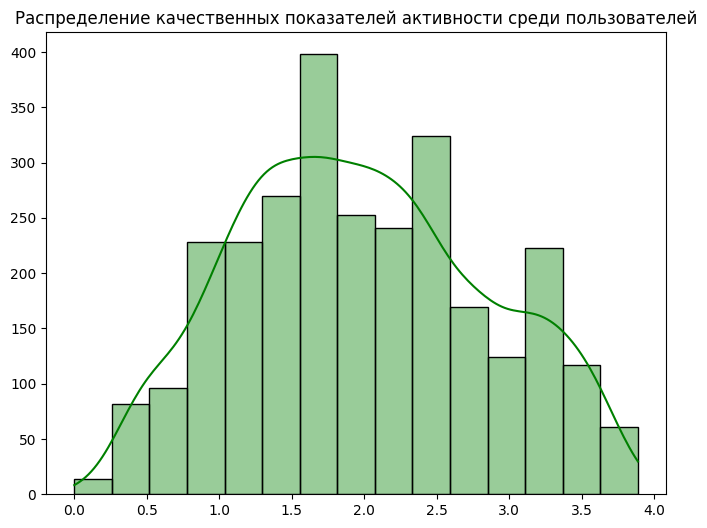

count    2828.000000
mean        1.976269
std         0.855551
min         0.000000
25%         1.333333
50%         1.888889
75%         2.555556
max         3.888889
dtype: float64

In [123]:
# Построим график
plt.figure(figsize=(8,6))
sns.histplot(vote_prof.mean(axis=1),kde=True, discrete=False, color="green",bins=15,alpha=0.4)
plt.title('Распределение качественных показателей активности среди пользователей')
plt.ylabel('')
plt.show()
display(vote_prof.mean(axis=1).describe())

* **Мы видим, что распределение качественных показателей активности пользователей общей выборки близко к нормальному с небольшим сдвигом в меньшую сторону**

# Кластеризация пользователей на основе показателей их активности

* **Проведем кластеризацию пользователей методом kmeans на основе их профилей с квартальными сегментами**

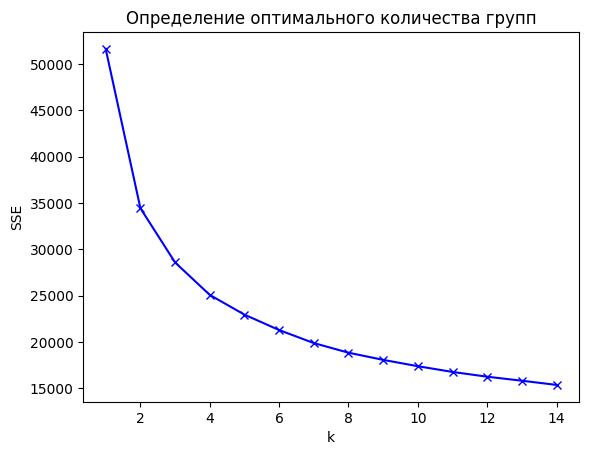

In [124]:
# определим оптимальное количество групп методом локтя 
Sum_of_squared_distances =[]
K = range(1,15)
for k in K:
    km =KMeans(n_clusters =k)
    km =km.fit(vote_prof)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Определение оптимального количества групп')
plt.show()

In [125]:
# подставим оптимальное значение для обучения модели, в нашем случае 4

kmeans = KMeans(n_clusters=4).fit(vote_prof)

In [126]:
# зададим группы значением цвета для cluster map 
row_colors =  pd.DataFrame( kmeans.labels_ )
row_colors['kmeans_group'] = kmeans.labels_

lut1 = dict(zip(set(kmeans.labels_), ['#ED2323','#60FD00','#6A5ACD','#000000']))
row_colors = row_colors['kmeans_group'].map(lut1)
row_colors.index = vote_prof.index
row_colors.head()

user
MarchHare1977    #60FD00
Q-bit array      #60FD00
Valdis72         #60FD00
Tempus           #60FD00
Simba16          #60FD00
Name: kmeans_group, dtype: object

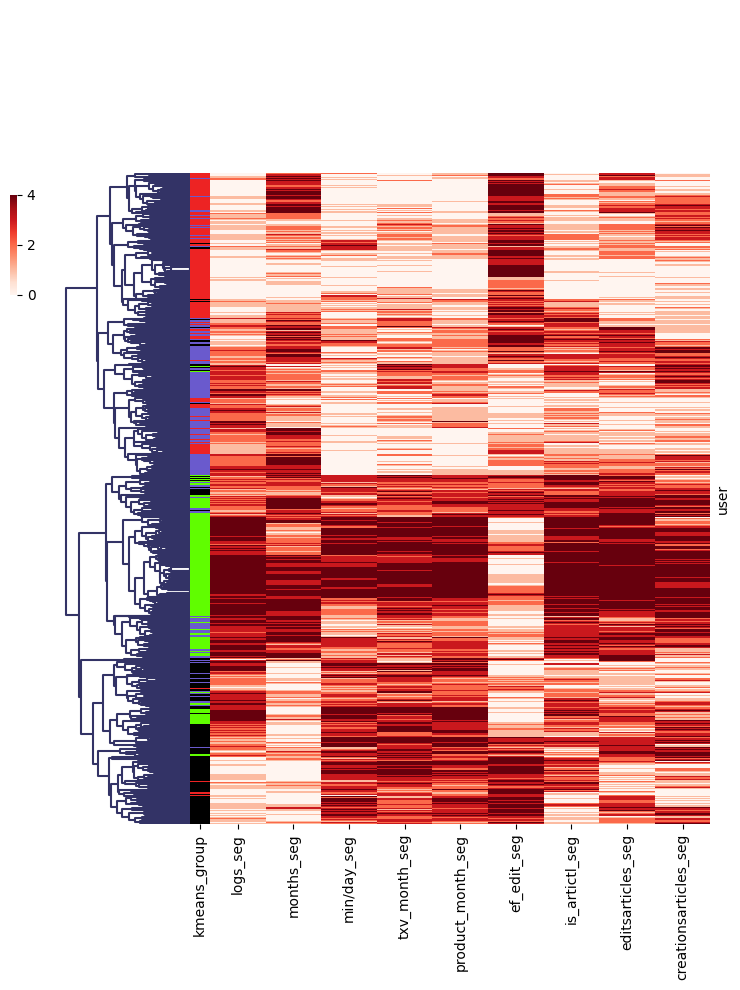

In [127]:
# Просторим тепловую карту с кластерами
h = sns.clustermap(vote_prof,annot=False,cbar_pos=(-0.05, .7, .01, .1), yticklabels=False, xticklabels=True,figsize=(7,10),tree_kws=dict(linewidths=1.5, colors=(0.2, 0.2, 0.4)),lw=0.0,
                   row_colors= row_colors, method="average",col_cluster=False,cmap="Reds")
plt.show()

* **Определим среднее значение качественного показателя среди всех профилей для сравнения с показателем получившихся кластеров**

In [128]:
# Определим 
main_mean = vote_prof.mean(axis=1).mean()
main_mean

1.9762690554769762

In [129]:
# добавим значение кластеров
vote_prof['kmg_quality'] = kmeans.labels_

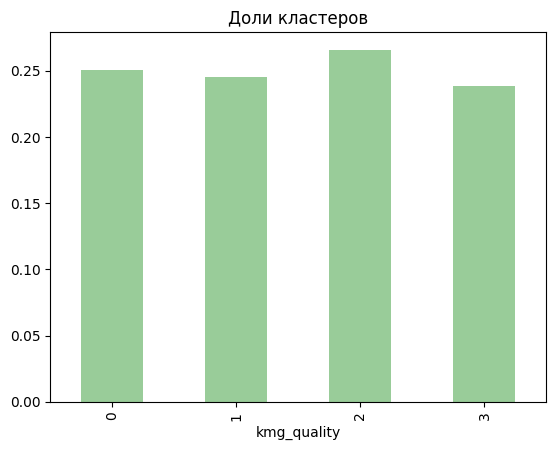

In [130]:
# определим доли пользователей в разных группах
share = vote_prof.groupby(by='kmg_quality')['kmg_quality'].count()/len(vote_prof)
share.plot(kind='bar',color='g',alpha=0.4)
plt.title('Доли кластеров')
plt.show()

* **Получилось 4 группы примерно равные по количеству пользователей**

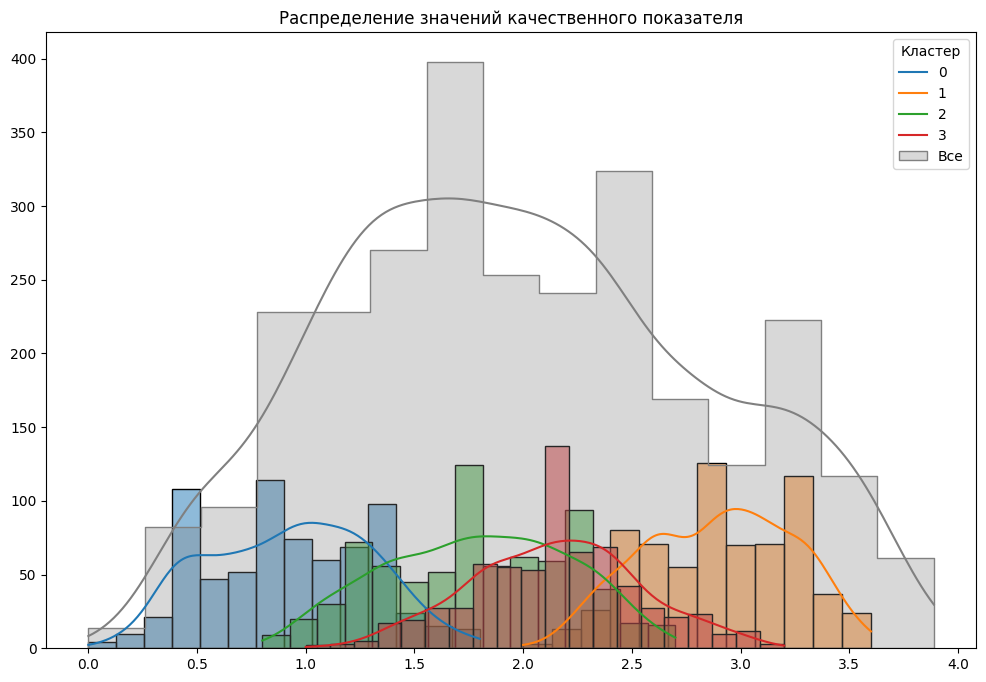

In [131]:
# посмотим на распределения значении их качественного показателя 
plt.figure(figsize=(12,8))
for i in range(4):
    sns.histplot(vote_prof.query("kmg_quality==@i" ).mean(axis=1), kde=True)

sns.histplot(vote_prof.drop('kmg_quality',axis=1).mean(axis=1), kde=True,color ='grey',alpha=0.3,bins=15,element="step",legend=True)
plt.legend(["0", "1", "2", "3",'Все'], title="Кластер")
plt.title('Распределение значений качественного показателя')
plt.ylabel('')
plt.show()

* **Мы видим что получившиеся кластеры имеют смещение качественного показателя активности относительно друг друга и общей выборки**

* **Посмотрим на особенности состава каждого кластера, посчитаем среднее значение по каждому показателю q сегмента**

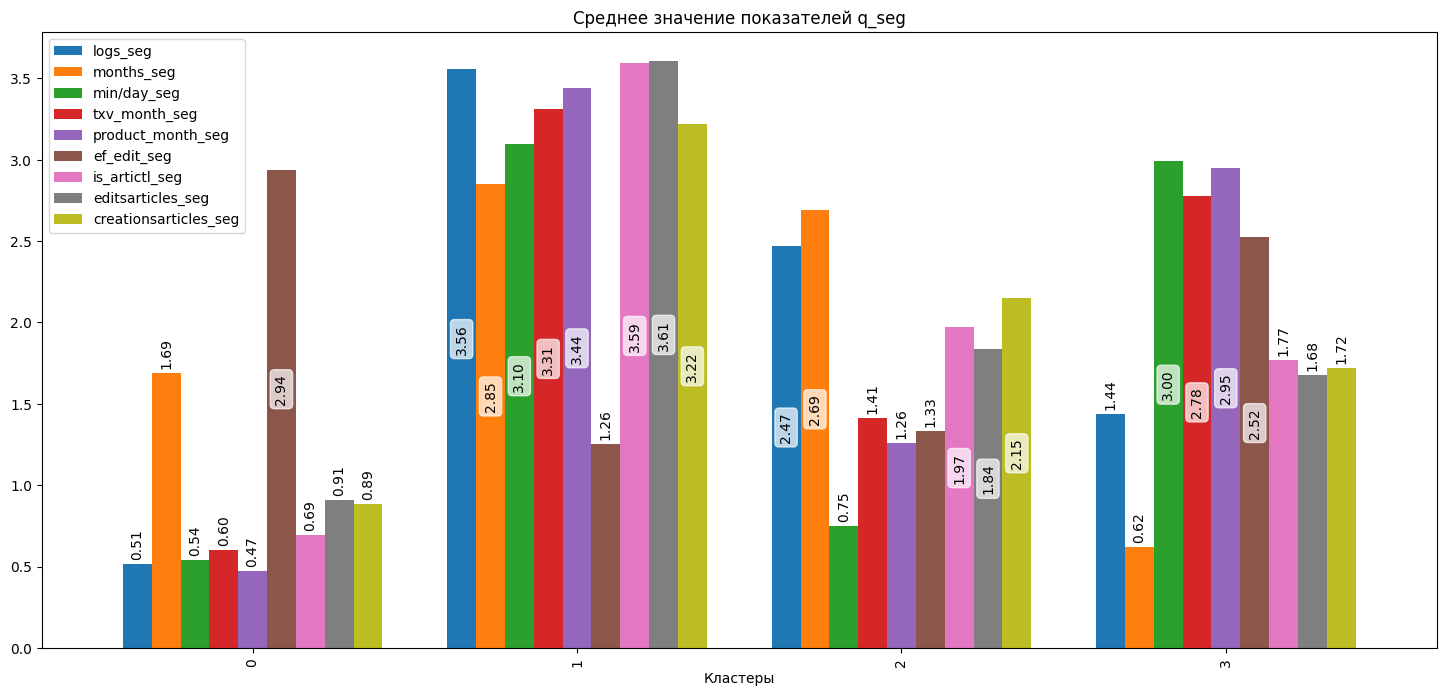

In [132]:
# график средних показателей q_seg
ax = vote_prof.groupby('kmg_quality').mean().plot(kind='bar',figsize=(18,8), width=0.8)
add_value_labels(ax,'bar', space=3,fmt='{:,.2f}')
plt.title('Среднее значение показателей q_seg')
plt.xlabel('Кластеры')
plt.show()

* **Мы видим существенные различия в качественных показателях между кластерами** 

### **Проверим уровень статистической значимости отличия сегментов от общей выборки**

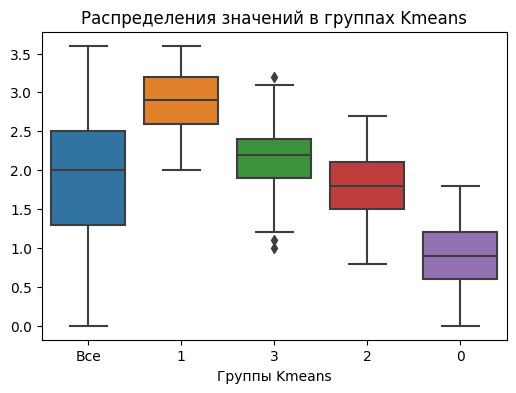

Все           1           3           2           0
count  2828.000000  693.000000  674.000000  752.000000  709.000000
mean      1.927829    2.893795    2.146884    1.786835    0.924965
std       0.802684    0.341755    0.388502    0.421429    0.373312
min       0.000000    2.000000    1.000000    0.800000    0.000000
25%       1.300000    2.600000    1.900000    1.500000    0.600000
50%       2.000000    2.900000    2.200000    1.800000    0.900000
75%       2.500000    3.200000    2.400000    2.100000    1.200000
max       3.600000    3.600000    3.200000    2.700000    1.800000

In [133]:
# выделим данные и построим графики 
all_kmg_quality = pd.DataFrame()
all_kmg_quality['Все'] = vote_prof.mean(axis=1)
for i in vote_prof.kmg_quality.unique():
    all_kmg_quality[i] = vote_prof.query("kmg_quality == @i").mean(axis=1)

plt.figure(figsize=(6,4))   
sns.boxplot(all_kmg_quality)
plt.xlabel('Группы Kmeans')
plt.title('Распределения значений в группах Kmeans')
plt.show()
display(all_kmg_quality.describe())

* **Проведем тест ANOVA** 

H0 - выборки равны

H1 - выборки не равны

In [134]:
# выделим данные
one =  all_kmg_quality[[0]].dropna()
two =  all_kmg_quality[[1]].dropna()
three = all_kmg_quality[[2]].dropna()
four = all_kmg_quality[[3]].dropna()


In [135]:
# проведем тест 

res = st.f_oneway(one, two, three, four)
print(res)

F_onewayResult(statistic=array([3195.67680677]), pvalue=array([0.]))


* **по результатам теста мы видим экстремально низкое значение P-value стремящиеся к 0, что говорит о существенных различиях качественного показателя  во всех выборках**

* **проведём т тест для сравнения каждой выборки с общей**

H0 - выборки равны

H1 - выборки не равны

In [136]:
# Проверим  уровень статистической значимости различий
for i in all_kmg_quality.columns[1:]:
  alpha = 0.05
  results = st.ttest_ind(all_kmg_quality["Все"].dropna(), all_kmg_quality[i].dropna())
  print('**************************************')
  print(f'p-значение пользователей, в {i} кластере: ', results.pvalue)
  if results.pvalue < alpha:
      print('Отвергаем нулевую гипотезу')
  else:
      print('Не получилось отвергнуть нулевую гипотезу')

**************************************
p-значение пользователей, в 1 кластере:  1.0067718808491644e-186
Отвергаем нулевую гипотезу
**************************************
p-значение пользователей, в 3 кластере:  6.381960825036058e-12
Отвергаем нулевую гипотезу
**************************************
p-значение пользователей, в 2 кластере:  3.453370987808243e-06
Отвергаем нулевую гипотезу
**************************************
p-значение пользователей, в 0 кластере:  7.404038395960515e-202
Отвергаем нулевую гипотезу


* **Мы видем что во всех  выборках имеются статистически значимые различия от общего набора данных** 

In [137]:
# Сравним среднее значение качественного показателя со значением общей выборки
diff_prof_main = vote_prof.groupby(by='kmg_quality').mean().mean(axis=1) - main_mean
diff_prof_main.sort_values()

kmg_quality
0   -0.948530
2   -0.213119
3    0.075825
1    1.127948
dtype: float64

In [138]:
# добавим значение кластеров
df_users['kmg_quality'] = kmeans.labels_

* **В зависимости от отклонения от основной выборки дадим название и запишем их**

In [139]:
# добавим колонку с названиями
tmp = diff_prof_main.sort_values()

row_colors =  pd.DataFrame( kmeans.labels_ )
row_colors['kmeans_group'] = kmeans.labels_

lut1 = dict(zip(tmp.index, ['kmg_low','kmg_m_low','kmg_m_high','kmg_high']))
row_colors = row_colors['kmeans_group'].map(lut1)
row_colors.index = vote_prof.index


df_users['kmg_quality_new'] = row_colors.values

In [140]:
# добавим поля с маркерами
df_users['kmg_low'] = df_users['kmg_quality']==diff_prof_main.sort_values().index[0]
df_users['kmg_m_low'] = df_users['kmg_quality']==diff_prof_main.sort_values().index[1]
df_users['kmg_m_high'] = df_users['kmg_quality']==diff_prof_main.sort_values().index[2]
df_users['kmg_high'] = df_users['kmg_quality']==diff_prof_main.sort_values().index[3]

In [141]:
df_users.fillna(0)


user groups  editstotal  editsedits  editsarticles  \
0         MarchHare1977      0      670625      658747         229189   
1           Q-bit array    COS      568443      278128         119067   
2              Valdis72      0      461773      268027         226018   
3                Tempus      0      372796      339636         269363   
4               Simba16      0      370125      333356         277881   
...                 ...    ...         ...         ...            ...   
2823    PrinzDinosavrov      0         566         523            501   
2824         Sinopsisus      0         562         551            514   
2825          Hausratte      0          51          49             17   
2826  Imaginary Rainbow      0           2           1              0   
2827       MaxBioHazard      0           1           1              0   

      creationspages  creationsarticles  textsvolume    logs  months  ...  \
0             423066              18263     79000000   11878      49  ...   
1              62470                 40    203000000  290315     103  ...   
2              36916              12295    116000000  193746     124  ...   
3              29679                922    141000000   33160     173  ...   
4              29413               5020     67000000   36769     135  ...   
...              ...                ...          ...     ...     ...  ...   
2823              35                 23       169000      43      17  ...   
2824               3                  0       206000      11      22  ...   
2825               1                  0        15000       2       7  ...   
2826               0                  0          405       1       1  ...   
2827               0                  0          173       0       1  ...   

     ef_edit_seg  is_artictl_seg  editsarticles_seg  creationsarticles_seg  \
0              4               4                  4                      4   
1              0               4                  4                      1   
2              0               4                  4                      4   
3              2               4                  4                      4   
4              2               4                  4                      4   
...          ...             ...                ...                    ...   
2823           2               0                  0                      1   
2824           4               0                  0                      0   
2825           3               0                  0                      0   
2826           0               0                  0                      0   
2827           4               0                  0                      0   

      kmg_quality  kmg_quality_new kmg_low kmg_m_low kmg_m_high kmg_high  
0               1         kmg_high   False     False      False     True  
1               1         kmg_high   False     False      False     True  
2               1         kmg_high   False     False      False     True  
3               1         kmg_high   False     False      False     True  
4               1         kmg_high   False     False      False     True  
...           ...              ...     ...       ...        ...      ...  
2823            0          kmg_low    True     False      False    False  
2824            0          kmg_low    True     False      False    False  
2825            0          kmg_low    True     False      False    False  
2826            0          kmg_low    True     False      False    False  
2827            0          kmg_low    True     False      False    False  

[2828 rows x 31 columns]

# Вывод по итогам кластеризации и сегментации пользователей по их профилям активности

* **Распределение качественных показателей активности пользователей общей выборки близко к нормальному с небольшим сдвигом в меньшую сторону**
* **По итогам кластеризации получилось 4 группы примерно равные по количеству пользователей**
* **Получившиеся кластеры имеют смещение качественного показателя активности относительно друг друга и общей выборки**
* **Мы видим существенные различия в средних значениях q сегментов между кластерами** 
* **По результатам ANOVA теста мы видим экстремально низкое значение P-value стремящиеся к 0, что говорит о статистически значимых различиях качественного показателя во всех выборках**
* **Мы видем что во всех группах kmeans имеются статистически значимые различия от общего набора данных, причем среднее имеет разного уровня отклонение как в большую тпу и меньшую сторону от общей выборки** 

# Анализ таблицы с данными о голосовании

In [142]:
# посмотрим на основную информацию
df_info(df_votes)

Количество полных дубликатов: 0
****************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16661 entries, 0 to 2738
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   voter      16661 non-null  object        
 1   can_vote   16661 non-null  bool          
 2   time       16661 non-null  datetime64[ns]
 3   candidate  16661 non-null  object        
 4   n          16661 non-null  int64         
 5   vote       16661 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(2)
memory usage: 797.3+ KB

NA:

groups    0.974187
dtype: float64

5750
voter               Флаттершай
can_vote                  True
time       2021-07-30 16:53:00
candidate    Alexander Roumega
n                           32
vote                        -1

True     15976
False      685
Name: can_vote, dtype: int64

32    4170
33    3374
34    3303
30    2041
35    1928
31    1845
Name: n, dtype: int64

 1    9747
-1    6914
Name: vote, dtype: int64

* **По общей информации видно, что пропусков в таблице нет, незасчитанных голосов 641 из 16857, электоральная активность неравномерна — самая высокая на 32 выборах самая низкая на 35**

In [143]:
# усечем дату до дней и часов - пригодится в дальнейшем 
df_votes['day'] = df_votes.time.astype(object).astype('datetime64[D]')
df_votes['hour'] = df_votes.time.astype(object).astype('datetime64[h]')
df_votes['day'].head() 

0   2020-07-30
1   2020-07-30
2   2020-07-30
3   2020-07-30
4   2020-08-02
Name: day, dtype: datetime64[ns]

* **Необходимо добавить информацию об активности пользователей к таблице с данными по голосованию, чтобы дополнить их профили информацией об ох электоральном поведении и провести полный анализ.**

In [144]:
# проверка
df_votes.vote.unique()

array([ 1, -1])

In [145]:
# добавим поле для объединения 
df_users['user_name'] = df_users['user'] 
df_votes['user_name'] = df_votes['voter']

In [146]:
# объеденим таблицы
df = df_votes.merge(df_users,how='left',on='user_name')
df.head()


voter  can_vote                time    candidate   n  vote  \
0      X0stark69      True 2020-07-30 11:55:00  Adamant.pwn  30     1   
1  Mike like0708      True 2020-07-30 09:32:00  Adamant.pwn  30    -1   
2     Brateevsky      True 2020-07-30 14:43:00  Adamant.pwn  30     1   
3   Forgottenous      True 2020-07-30 08:09:00  Adamant.pwn  30     1   
4        Swarrel      True 2020-08-02 14:57:00  Adamant.pwn  30     1   

         day                hour      user_name           user  ...  \
0 2020-07-30 2020-07-30 11:00:00      X0stark69      X0stark69  ...   
1 2020-07-30 2020-07-30 09:00:00  Mike like0708  Mike like0708  ...   
2 2020-07-30 2020-07-30 14:00:00     Brateevsky     Brateevsky  ...   
3 2020-07-30 2020-07-30 08:00:00   Forgottenous   Forgottenous  ...   
4 2020-08-02 2020-08-02 14:00:00        Swarrel        Swarrel  ...   

  ef_edit_seg  is_artictl_seg  editsarticles_seg  creationsarticles_seg  \
0           0               4                  4                      1   
1           0               1                  0                      0   
2           0               4                  3                      3   
3           0               2                  1                      1   
4           0               3                  2                      3   

   kmg_quality  kmg_quality_new  kmg_low  kmg_m_low  kmg_m_high kmg_high  
0          1.0         kmg_high    False      False       False     True  
1          2.0        kmg_m_low    False       True       False    False  
2          1.0         kmg_high    False      False       False     True  
3          3.0       kmg_m_high    False      False        True    False  
4          1.0         kmg_high    False      False       False     True  

[5 rows x 40 columns]

In [147]:
# уберем плохие голоса
df = df.loc[df['can_vote']==True]


In [148]:
# список голосовавших людей без информации о активности
display(df.loc[df['kmg_quality'].isna()].voter.drop_duplicates())


108         Алёна Синичкина
122                  Reddle
430                Сайга20К
2045              Grebenkov
2069         Timur Rossolov
2073              Jack Pomi
2134                 Telovg
2315             Semenov.m7
2481                 Mrakia
7778              Oswiecony
8241     Станислав Савченко
8263                Cchrx23
11482        Italia Ispania
11562           Jolf Staler
14800                Avburg
Name: voter, dtype: object

In [149]:
# уберем чтобы избежать искажений
df =df.loc[~df['kmg_quality'].isna()]

## Сравнительный анализ активности групп пользователей и голосующих

* **Проверим пропорции кластеров в группе принимавшей участие в голосованиях**

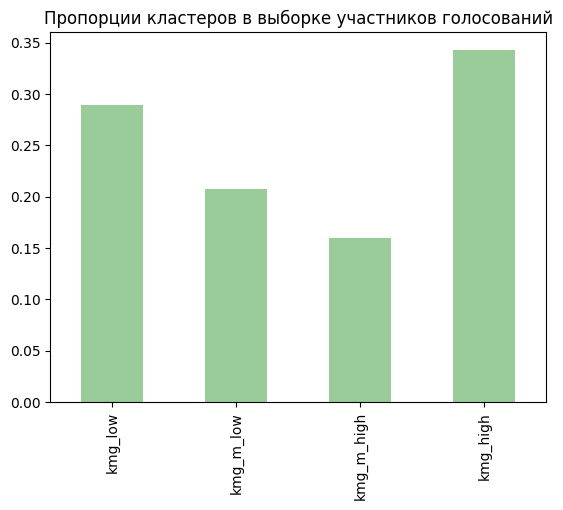

In [150]:
# Посчитаем
df[['voter','kmg_low','kmg_m_low','kmg_m_high','kmg_high']].drop_duplicates().drop('voter',axis=1).mean().plot(kind='bar',color='green',alpha=0.4)
plt.title('Пропорции кластеров в выборке участников голосований')
plt.show()

* **Посмотрим на пропорции кластеров у кандидатов и голосующих**

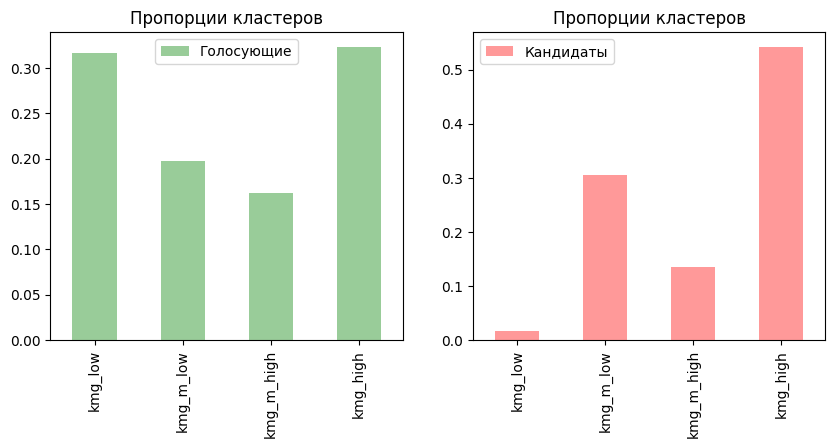

In [151]:
ax = plt.subplot(1,2,1)
df.query("voter not in candidate")[['voter','kmg_low','kmg_m_low','kmg_m_high','kmg_high']].drop_duplicates().mean().plot(kind='bar',color='green',alpha=0.4,ax=ax)
plt.legend(['Голосующие'])
plt.title('Пропорции кластеров')

ax1= plt.subplot(1,2,2)
df.query("voter  in candidate")[['voter','kmg_low','kmg_m_low','kmg_m_high','kmg_high']].drop_duplicates().mean().plot(kind='bar',color='red',alpha=0.4,ax=ax1,figsize=(10,4))
plt.legend(['Кандидаты'])
plt.title('Пропорции кластеров')
plt.show()

* **Видна асимметрия в сторону старших кластеров у всех участников выборов, что может говорить о том что в выборах принимают более активные пользователи с большим стажем. Основная часть кандидатов попала в high сегмент, тогда как в сегменте с самым низким показателем активности у них явный дефицит**

## Сравнение показателей активности кандидатов, голосующих и юзеров

In [152]:
# выделим группы поьзователей 
voter_quality = df.query("voter not in candidate")[['voter','logs_seg','months_seg','min/day_seg','txv_month_seg','product_month_seg','ef_edit_seg','is_artictl_seg','editsarticles_seg','creationsarticles_seg']].drop_duplicates().drop('voter',axis=1).mean(axis=1).fillna(0)

candidate_quality = df.query("voter in candidate")[['voter','logs_seg','months_seg','min/day_seg','txv_month_seg','product_month_seg','ef_edit_seg','is_artictl_seg','editsarticles_seg','creationsarticles_seg']].drop_duplicates().drop('voter',axis=1).mean(axis=1).fillna(0)

users_quality = df_users.query("user not in @df.voter")[['user','logs_seg','months_seg','min/day_seg','txv_month_seg','product_month_seg','ef_edit_seg','is_artictl_seg','editsarticles_seg','creationsarticles_seg']].drop_duplicates().drop('user',axis=1).mean(axis=1).fillna(0)

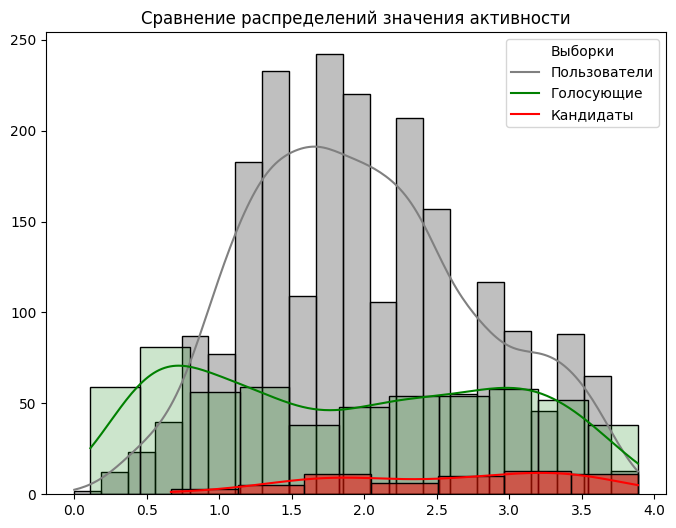

'voter'

count    597.000000
mean       1.888703
std        1.061114
min        0.111111
25%        0.888889
50%        1.888889
75%        2.777778
max        3.888889
dtype: float64

'candidate'

count    59.000000
mean      2.566855
std       0.815112
min       0.666667
25%       1.833333
50%       2.666667
75%       3.277778
max       3.888889
dtype: float64

'users'

count    2172.000000
mean        1.984295
std         0.783985
min         0.000000
25%         1.333333
50%         1.888889
75%         2.555556
max         3.888889
dtype: float64

In [153]:
# Построим график
plt.figure(figsize=(8,6))
sns.histplot(users_quality,legend = True,color='grey',kde=True)
sns.histplot(voter_quality, legend = True,color='green',kde=True,alpha=0.2)
sns.histplot(candidate_quality,legend = True,alpha=0.5,color='red',kde=True)
plt.legend(['Пользователи','Голосующие','Кандидаты'],title='Выборки')
plt.ylabel('')
plt.title('Сравнение распределений значения активности')
plt.show()
display('voter',voter_quality.describe(),'candidate',candidate_quality.describe(),'users',users_quality.describe())

**Видим явное смещение показателей кандидатов в большую сторону, тогда как показатель голосующих относительно равномерно распределены.**

## Проведём т тест для выявления статистически значимых различий между выборками.

H0 - выборки равны

H1 - выборки не равны

In [154]:
# сравним кандидатов и голосующих
alpha = 0.01
results = st.ttest_ind(candidate_quality.values, voter_quality.values)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  2.267420042819359e-06
Отвергаем нулевую гипотезу


По результатам теста мы видим очень низкое значение уровня значимости, поэтому можно смело сказать что Кандидаты и Голосующие имеют существенные различия.

* **Сравним качественный показатель голосующих и пользователей**

H0 - выборки равны

H1 - выборки не равны

In [155]:
# сравним голосующих и пользователей 
alpha = 0.01
results = st.ttest_ind(voter_quality.values, users_quality.values,equal_var= True)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.015168563636286731
Не получилось отвергнуть нулевую гипотезу


 По результатам теста можно сказать, что голосующие несильно, но довольно значимо отличаются от пользователей.

# Вывод по результатам сравнительного анализа качественного показателя активности пользователей и голосующих

* **Видна асимметрия по составу голосующих пользователей в сторону старших кластеров у всех участников выборов, что может говорить о том что в выборах принимают более активные пользователи с большим стажем. Основная часть кандидатов попала в high сегмент, тогда как в сегменте с самым низким показателем активности у них явный дефицит**
* **Явное смещение качественных показателей активности кандидатов в большую сторону, тогда как показатель голосующих относительно равномерно распределены**
* **По результатам теста мы видим очень низкое значение уровня значимости, поэтому можно смело сказать что Кандидаты и Голосующие имеют существенные различия**
* **По результатам теста можно сказать, что голосующие несильно, но довольно значимо отличаются от пользователей**

 **Зададим функцию для расчета всех необходимых для анализа параметров**
  * *Помимо прочего в функции происходит вычисление 4 показателей электорального поведения, которые записываются в профиль голосующего*
    * **conf -  склонен ли к конформизму**
    * **oport - склонен ли к оппортунизму**
    * **is_definded - определился и отдал все свои голоса в один день**
    * **all_voter - отдал  максимально возможное количество голосов**

In [156]:

def voters_itog_wiki(n, df):
    ''' принимает 2 параметра - номер выборов и дата фрейм с информацией о голосовании
         
         на выходе получаем: vote_history - таблица с изменением результата голосования по дням
                             result – результат со списком кандидатов и процентов голосов за
                             winners - список победителей
                             negative_vote - доля протестных голосов по дням голосования
                             voters - список голосовавших на выборах
                             losers - список проигравших кандидатов
                             voters_profile_qsg - профили пользователей с сегментами по квартилям
                             voters_profile_kmg - профили с группами kmean
                             vot_cand - таблица голосования 
                             conferm_values - уровень конформизма
    '''
    df_votes = df.loc[df['n']==n]
    
    
    # Create count of votes table
    cv = df_votes.groupby(by=['day','candidate'])['vote'].count().reset_index()
    cv = cv.pivot_table(index = 'candidate', columns = 'day',values = 'vote').drop_duplicates().cumsum(axis = 1).fillna(0)


    
    # create sum positive votes table 
    d = df_votes.loc[(df_votes['vote']>=0)].groupby(by=['day','candidate'])['vote'].sum().reset_index()
    d = d.pivot_table(index = 'candidate', columns = 'day',values = 'vote').drop_duplicates().cumsum(axis = 1).fillna(0)
    


    # create final table  
    vote_history = d/cv
    vote_history = vote_history.replace({'0':np.nan, 0:np.nan})

    # result 
    result = vote_history[vote_history.columns[-1]]
    
    # winners 
    winners = vote_history[vote_history.columns[-1]][vote_history[vote_history.columns[-1]]>0.66666666]
    
    
    # losers
    losers = vote_history[vote_history.columns[-1]][vote_history[vote_history.columns[-1]]<=0.66666666]


    # share votes fy day
    active_vote = df_votes.groupby(by=['day'])['vote'].count().fillna(0)/df_votes.groupby(by=['day'])['vote'].count().fillna(0).sum()
    ######################### ELECTED PART OF THE DIF ################################
    
    # add confirm mark  and apport mark 
    
    df_ = df_votes
    df_['pos_win'] = df_['candidate'].isin(winners.index)& (df_['vote']==1)
    df_['neg_lo'] = df_['candidate'].isin(losers.index)& (df_['vote']==-1)
    
    df_['conf'] = df_[['pos_win','neg_lo']].sum(axis=1) 
    df_ = df_[['voter','conf']]
    conferm_values = df_
    # add mean values
    df_ = df_.groupby(by='voter')['conf'].mean()
    oport = df_

    # add oport mark 
    oport = df_<0.5
    oport = oport.to_frame()
    oport.columns = ['oport']
    # add conf mark
    df_ = df_>0.77
    df_ = df_.to_frame()
  

    
    
    # add all_valer mark and is_definded mark 
    tmp =df_votes.loc[(df_votes['n']==n)].groupby(by=['voter'])['day'].agg(['nunique','count'])
    tmp['is_definded'] = tmp['nunique'] == 1
    tmp['all_voter'] = tmp['count'] == len(result.T)
    tmp = tmp[['is_definded','all_voter']]
    
    # create table with elect kmg_profiles of voters
    voters_profile = df_votes[['voter','kmg_low','kmg_m_low','kmg_m_high','kmg_high']]
    voters_profile = voters_profile.drop_duplicates()
    voters_profile.index = voters_profile['voter']
    voters_profile = voters_profile.drop('voter',axis = 1)

    # add elect mark to kmg_profile
    voters_profile = voters_profile.join(tmp)
    voters_profile = voters_profile.join(df_)
    voters_profile = voters_profile.join(oport)
    voters_profile_kmg = voters_profile.fillna(0).astype(int).copy()
    

    #create table with q_seg_voter prof
    voters_profile_qseg = df_votes[['voter','logs_seg', 'months_seg', 'min/day_seg', 'txv_month_seg',
       'product_month_seg', 'ef_edit_seg', 'is_artictl_seg','editsarticles_seg','creationsarticles_seg']]
    voters_profile_qseg = voters_profile_qseg.drop_duplicates()
    voters_profile_qseg.index = voters_profile_qseg['voter']
    voters_profile_qseg = voters_profile_qseg.drop('voter',axis = 1)
    

    
    # add elect mark 
    voters_profile_qseg = voters_profile_qseg.join(tmp)
    voters_profile_qseg = voters_profile_qseg.join(df_)
    voters_profile_qseg = voters_profile_qseg.join(oport)
    voters_profile_qseg = voters_profile_qseg.fillna(0).astype(int)
    
    # create voters/candidate table
    votes_table = df_votes.loc[(df_votes['n']==n)].pivot_table(index=['voter',],columns='candidate',values='vote').fillna(0)
    #votes_table = votes_table.fillna(0).astype(int)
    
    
    return vote_history, result, winners, active_vote, losers, voters_profile_kmg, voters_profile_qseg, votes_table, conferm_values

In [157]:
# проверим
history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values= voters_itog_wiki(33, df)
display(kmg_voters_profile.head())
display(voters_profile_qseg.head())
display(active_vote.head())

kmg_low  kmg_m_low  kmg_m_high  kmg_high  is_definded  \
voter                                                                         
MasterRus21thCentury        0          0           1         0            1   
DragonSpace                 0          1           0         0            1   
Dipish mot                  0          1           0         0            1   
Kenpav                      0          0           1         0            1   
Medvednikita                1          0           0         0            1   

                      all_voter  conf  oport  
voter                                         
MasterRus21thCentury          1     0      0  
DragonSpace                   1     0      0  
Dipish mot                    1     0      0  
Kenpav                        0     0      0  
Medvednikita                  0     1      0

logs_seg  months_seg  min/day_seg  txv_month_seg  \
voter                                                                    
MasterRus21thCentury         2           1            3              4   
DragonSpace                  3           1            2              1   
Dipish mot                   2           1            0              2   
Kenpav                       2           2            4              1   
Medvednikita                 1           0            0              3   

                      product_month_seg  ef_edit_seg  is_artictl_seg  \
voter                                                                  
MasterRus21thCentury                  3            2               3   
DragonSpace                           2            0               2   
Dipish mot                            1            1               2   
Kenpav                                4            3               3   
Medvednikita                          1            0               1   

                      editsarticles_seg  creationsarticles_seg  is_definded  \
voter                                                                         
MasterRus21thCentury                  2                      3            1   
DragonSpace                           0                      1            1   
Dipish mot                            0                      1            1   
Kenpav                                4                      1            1   
Medvednikita                          0                      0            1   

                      all_voter  conf  oport  
voter                                         
MasterRus21thCentury          1     0      0  
DragonSpace                   1     0      0  
Dipish mot                    1     0      0  
Kenpav                        0     0      0  
Medvednikita                  0     1      0

day
2022-01-30    0.605076
2022-01-31    0.106469
2022-02-01    0.060972
2022-02-02    0.043330
2022-02-03    0.040235
Name: vote, dtype: float64

## Анализ склонности к конформизму голосующих пользователей общей выборки

In [158]:

# соберём данные 
voter_conform = pd.DataFrame()
for i in df.n.unique():
  history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values = voters_itog_wiki(i, df)
  voter_conform = pd.concat([voter_conform,conferm_values],ignore_index=False)

voter_conform = voter_conform.groupby(by='voter').mean()

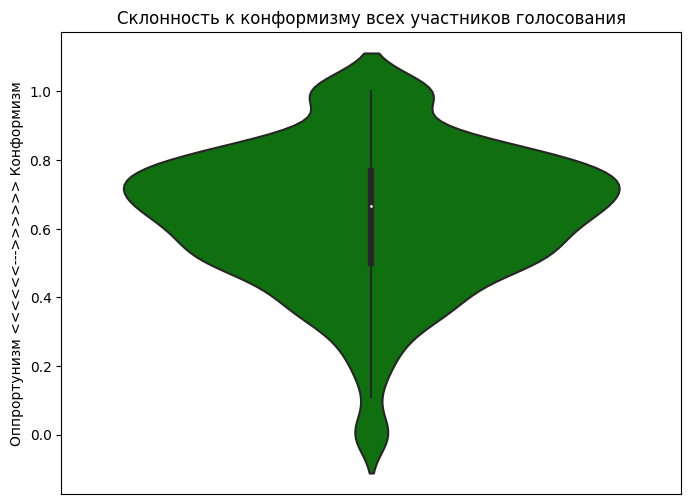

             conf
count  656.000000
mean     0.634961
std      0.204420
min      0.000000
25%      0.500000
50%      0.666667
75%      0.769231
max      1.000000


In [159]:
# построим график 
plt.figure(figsize =(8,6))
sns.violinplot(voter_conform, color ="green", alpha=0.4)
plt.ylabel('Оппрортунизм <<<<<<--->>>>>> Конформизм')
plt.title('Склонность к конформизму всех участников голосования')
plt.xticks([])
plt.show()

print(voter_conform.describe())

* **На графике видно, что в целом участники голосования больше склонны к конформизму**

* **Определим пользователей больше склонных к конформизму и оппортунизму по значениям больше 3 и  меньше 1 квартилей общей выборки соответственно**

### Сравнение уровня склонности к конформизму у кандидатов и голосующих

In [160]:
# отберем список кандидатов
candidate = df.query("voter in candidate")["voter"]

In [161]:
# добавим к общей выборке информацию для кандидатов и голосующих
voter_conform["Кандидаты"] = voter_conform.query("voter in @candidate")["conf"]

voter_conform["Голосующие"] = voter_conform.query("voter not in @candidate")["conf"]

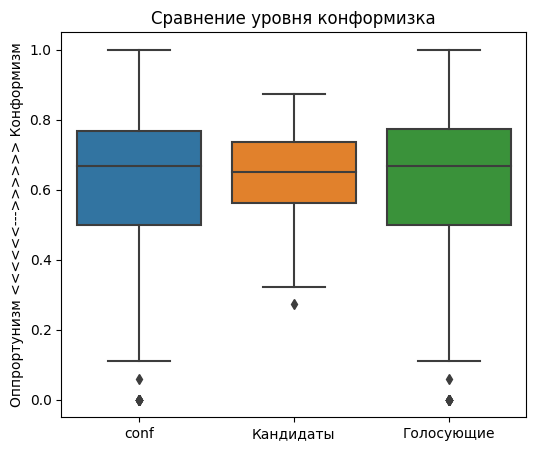

             conf  Кандидаты  Голосующие
count  656.000000  59.000000  597.000000
mean     0.634961   0.637773    0.634683
std      0.204420   0.133482    0.210213
min      0.000000   0.272727    0.000000
25%      0.500000   0.561829    0.500000
50%      0.666667   0.651515    0.666667
75%      0.769231   0.735714    0.774194
max      1.000000   0.875000    1.000000


In [162]:
# построим боксы для сравнения
plt.figure(figsize =(6,5))
sns.boxplot(voter_conform)
plt.ylabel('Оппрортунизм <<<<<<--->>>>>> Конформизм')
plt.title('Сравнение уровня конформизка')
plt.show()

print(voter_conform.describe())

H0 - выборки равны

H1 - выборки не равны

In [163]:
# Проверим  уровень статистической значимости различий
for i in voter_conform.columns[1:]:
  alpha = 0.05
  results = st.ttest_ind(voter_conform["conf"].dropna(), voter_conform[i].dropna())
  print('**************************************')
  print(f'p-значение между, всеми и {i} : ', results.pvalue)
  if results.pvalue < alpha:
      print('Отвергаем нулевую гипотезу')
  else:
      print('Не получилось отвергнуть нулевую гипотезу')

**************************************
p-значение между, всеми и Кандидаты :  0.9174638146977695
Не получилось отвергнуть нулевую гипотезу
**************************************
p-значение между, всеми и Голосующие :  0.9810843612958215
Не получилось отвергнуть нулевую гипотезу


* **Существенных различий в уровне конформизма нет между кандидатами, голосующими и общей выборкой**

### Проведём сравнительный анализ склонности пользователей к конформизму в сегментах кластерного анализа

In [164]:

# выделим списки пользователей 
kmg_low = df.query("kmg_low==1")[["voter"]].drop_duplicates()
kmg_m_low = df.query("kmg_m_low==1")[["voter"]].drop_duplicates()
kmg_m_high = df.query("kmg_m_high==1")[["voter"]].drop_duplicates()
kmg_high = df.query("kmg_high==1")[["voter"]].drop_duplicates()

In [165]:

#соберём данные 
voter_conform = pd.DataFrame()
for i in df.n.unique():
  history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values = voters_itog_wiki(i, df)
  voter_conform = pd.concat([voter_conform,conferm_values],ignore_index=False)

voter_conform = voter_conform.groupby(by='voter').mean()


voter_conform["kmg_low"] = voter_conform.query("voter in @kmg_low.voter")
voter_conform["kmg_m_low"] = voter_conform.query("voter in @kmg_m_low.voter")['conf']
voter_conform["kmg_m_high"] = voter_conform.query("voter in @kmg_m_high.voter")['conf']
voter_conform["kmg_high"] = voter_conform.query("voter in @kmg_high.voter")['conf']
voter_conform.columns = ["Все", "kmg_low", "kmg_m_low", "kmg_m_high", "kmg_high"]

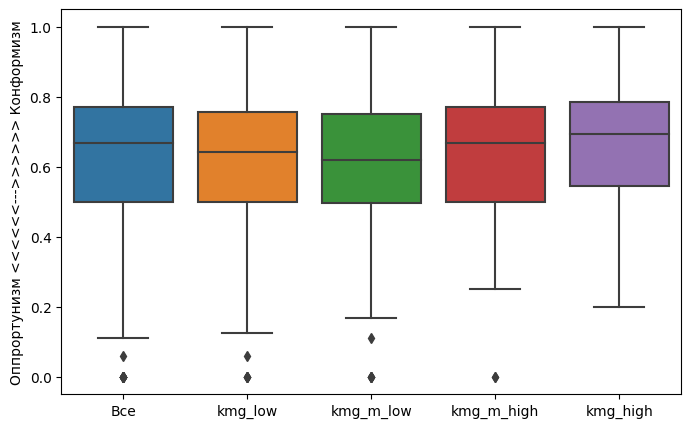

              Все     kmg_low   kmg_m_low  kmg_m_high    kmg_high
count  656.000000  190.000000  136.000000  105.000000  225.000000
mean     0.634961    0.617717    0.594898    0.638311    0.672175
std      0.204420    0.217649    0.227985    0.206987    0.168468
min      0.000000    0.000000    0.000000    0.000000    0.200000
25%      0.500000    0.500000    0.496795    0.500000    0.545455
50%      0.666667    0.642857    0.618034    0.666667    0.692308
75%      0.769231    0.757500    0.751453    0.769231    0.785714
max      1.000000    1.000000    1.000000    1.000000    1.000000


In [166]:
plt.figure(figsize =(8,5))
sns.boxplot(voter_conform)
plt.ylabel('Оппрортунизм <<<<<<--->>>>>> Конформизм')
plt.show()

print(voter_conform.describe())

* **Можно заметить что в первых двух группах среднее значение ниже общего, а в следующих — выше**

* **Проведем тест ANOVA для выявления статистически зничимых различий мижду kmeans группами**

In [167]:
res = st.f_oneway(voter_conform['kmg_low'].dropna(), voter_conform['kmg_m_low' ].dropna(), voter_conform['kmg_m_high'].dropna(), voter_conform['kmg_high'].dropna())
print(res)

F_onewayResult(statistic=4.76774893713201, pvalue=0.002695969103232143)


* **По результатам теста мы можем говорть о наличии значимых различий уровня конформизма среди kmeans групп**

* **Проведем т тест**

H0 - выборки равны

H1 - выборки не равны

In [168]:
# проверим уровень стат значимости различий
for i in voter_conform.columns[1:]:
  alpha = 0.05
  results = st.ttest_ind(voter_conform["Все"].dropna(), voter_conform[i].dropna())
  print('**************************************')
  print(f'p-значение между всеми и {i} : ', results.pvalue)
  if results.pvalue < alpha:
      print('Отвергаем нулевую гипотезу')
  else:
      print('Не получилось отвергнуть нулевую гипотезу')

**************************************
p-значение между всеми и kmg_low :  0.31331669149304264
Не получилось отвергнуть нулевую гипотезу
**************************************
p-значение между всеми и kmg_m_low :  0.041876999757647373
Отвергаем нулевую гипотезу
**************************************
p-значение между всеми и kmg_m_high :  0.8763661000087739
Не получилось отвергнуть нулевую гипотезу
**************************************
p-значение между всеми и kmg_high :  0.014124323267643188
Отвергаем нулевую гипотезу


* **По результатам сравнения мы увидели статистически значимые различия в уровне конформизма в кластерах kmg_m_low и kmg_high в  меньшую и большую сторону относительно общей выборки соответственно**

### Распределений пользователей по количеству участий в выборах

In [169]:
# соберем данные
count_vote = {}
for i in range(1,len(df.n.unique())+1):

  count_vote[i] = len(df.groupby('voter', as_index = False)['n'].nunique().query('n == @i')['voter'])
count_vote = pd.Series(count_vote, name='Voter_in_elect')

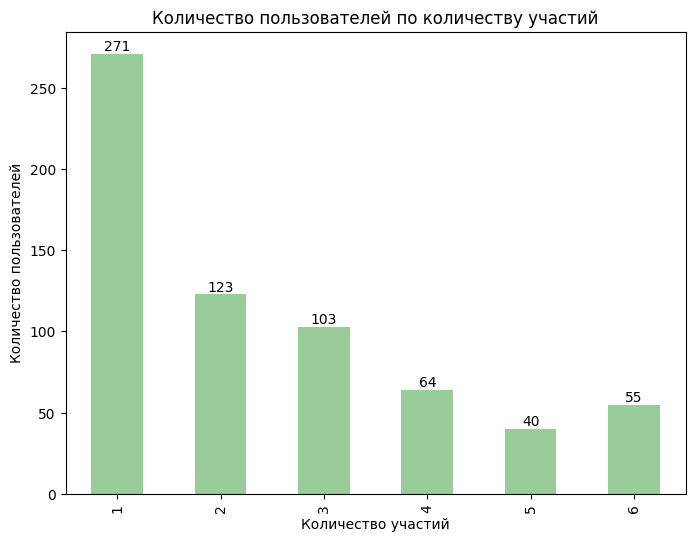

In [170]:
# построим график
plt.figure(figsize=(8,6))
ax = count_vote.plot(kind='bar',color='green',alpha=0.4)
for i, v in enumerate(count_vote):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.title('Количество пользователей по количеству участий')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество участий')
plt.show()

* **Можно заметить что основная часть голосующих принимает участие в одних выборах, далее с возрастание количества участий количество голосующих линейно снижается, однако 6 раз выборах приняли участие больше людей чем в 5**

### Сравнительный анализ уровня конформизма между группами голосующих по количеству участий в выборах и общей выборкой

In [171]:
# соберем данные
voter_conform = pd.DataFrame()
for i in df.n.unique():
  history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values = voters_itog_wiki(i, df)
  voter_conform = pd.concat([voter_conform,conferm_values],ignore_index=False)

voter_conform = voter_conform.groupby(by='voter').mean()

for i in range(1,len(df.n.unique())+1):
  tmp = df.groupby('voter', as_index = False)['n'].nunique().query('n == @i')['voter']
  voter_conform[i] = voter_conform.query("voter in @tmp")['conf']

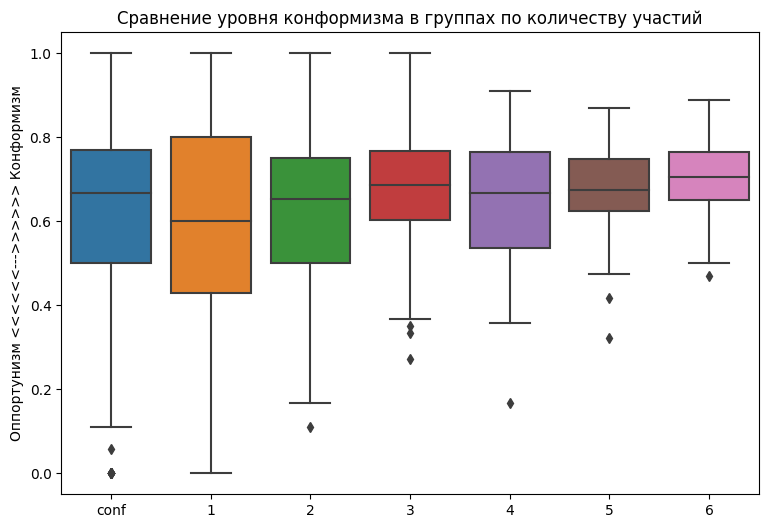

             conf           1           2           3          4          5  \
count  656.000000  271.000000  123.000000  103.000000  64.000000  40.000000   
mean     0.634961    0.604612    0.626873    0.668403   0.646961   0.670406   
std      0.204420    0.263051    0.167145    0.141774   0.151455   0.120530   
min      0.000000    0.000000    0.111111    0.272727   0.166667   0.322581   
25%      0.500000    0.428571    0.500000    0.602326   0.537179   0.625000   
50%      0.666667    0.600000    0.652174    0.687500   0.666667   0.674166   
75%      0.769231    0.800000    0.750000    0.766907   0.764706   0.747845   
max      1.000000    1.000000    1.000000    1.000000   0.909091   0.869565   

               6  
count  55.000000  
mean    0.700215  
std     0.101030  
min     0.470588  
25%     0.650319  
50%     0.704545  
75%     0.765957  
max     0.888889  


In [172]:
# построим график для сравнения
plt.figure(figsize =(9,6))
sns.boxplot(voter_conform)
plt.ylabel('Оппортунизм <<<<<<--->>>>>> Конформизм')
plt.title('Сравнение уровня конформизма в группах по количеству участий')
plt.show()

print(voter_conform.describe())

H0 - выборки равны

H1 - выборки не равны

In [173]:
# проверим уровень статистической значимоти различий
for i in voter_conform.columns[1:]:
  alpha = 0.05
  results = st.ttest_ind(voter_conform["conf"].dropna(), voter_conform[i].dropna())
  print("***********")
  print(f'p-значение пользователей, учавствовавывщих в {i} выборах и общей выборки: ', results.pvalue)
  if results.pvalue < alpha:
      print('Отвергаем нулевую гипотезу')
  else:
      print('Не получилось отвергнуть нулевую гипотезу')

***********
p-значение пользователей, учавствовавывщих в 1 выборах и общей выборки:  0.05994068900049102
Не получилось отвергнуть нулевую гипотезу
***********
p-значение пользователей, учавствовавывщих в 2 выборах и общей выборки:  0.6792806399726872
Не получилось отвергнуть нулевую гипотезу
***********
p-значение пользователей, учавствовавывщих в 3 выборах и общей выборки:  0.10989513681453755
Не получилось отвергнуть нулевую гипотезу
***********
p-значение пользователей, учавствовавывщих в 4 выборах и общей выборки:  0.6475044929532261
Не получилось отвергнуть нулевую гипотезу
***********
p-значение пользователей, учавствовавывщих в 5 выборах и общей выборки:  0.27842687770904484
Не получилось отвергнуть нулевую гипотезу
***********
p-значение пользователей, учавствовавывщих в 6 выборах и общей выборки:  0.019437341301720642
Отвергаем нулевую гипотезу


* **По результатам сравнительного анализа мы можем сделать вывод, что пользователи, принявшие участие в 6 выборах, имеют статистически значимый уровень отличия конформизме от общей выборки, причем это отличие в большей склонности к конформизму**

# Анализ группы, принявшей участие в 6 выборах

* **Выделим группу пользователей, участвовавших в 6 выборах. Составим таблицу, где ряды будут эти голосующие, а строки кандидаты за которых они голосовали. Значением будет сумма их голосов. Далее к этой таблице добавим таблицу с суммой маркеров электорального поведения. В результате будет таблица, с возможностью анализа постоянства голосования этих пользователей и стабильности их электорального поведения**

In [174]:
df.groupby('candidate', as_index = False)['n'].nunique().query('n == 6')

Empty DataFrame
Columns: [candidate, n]
Index: []

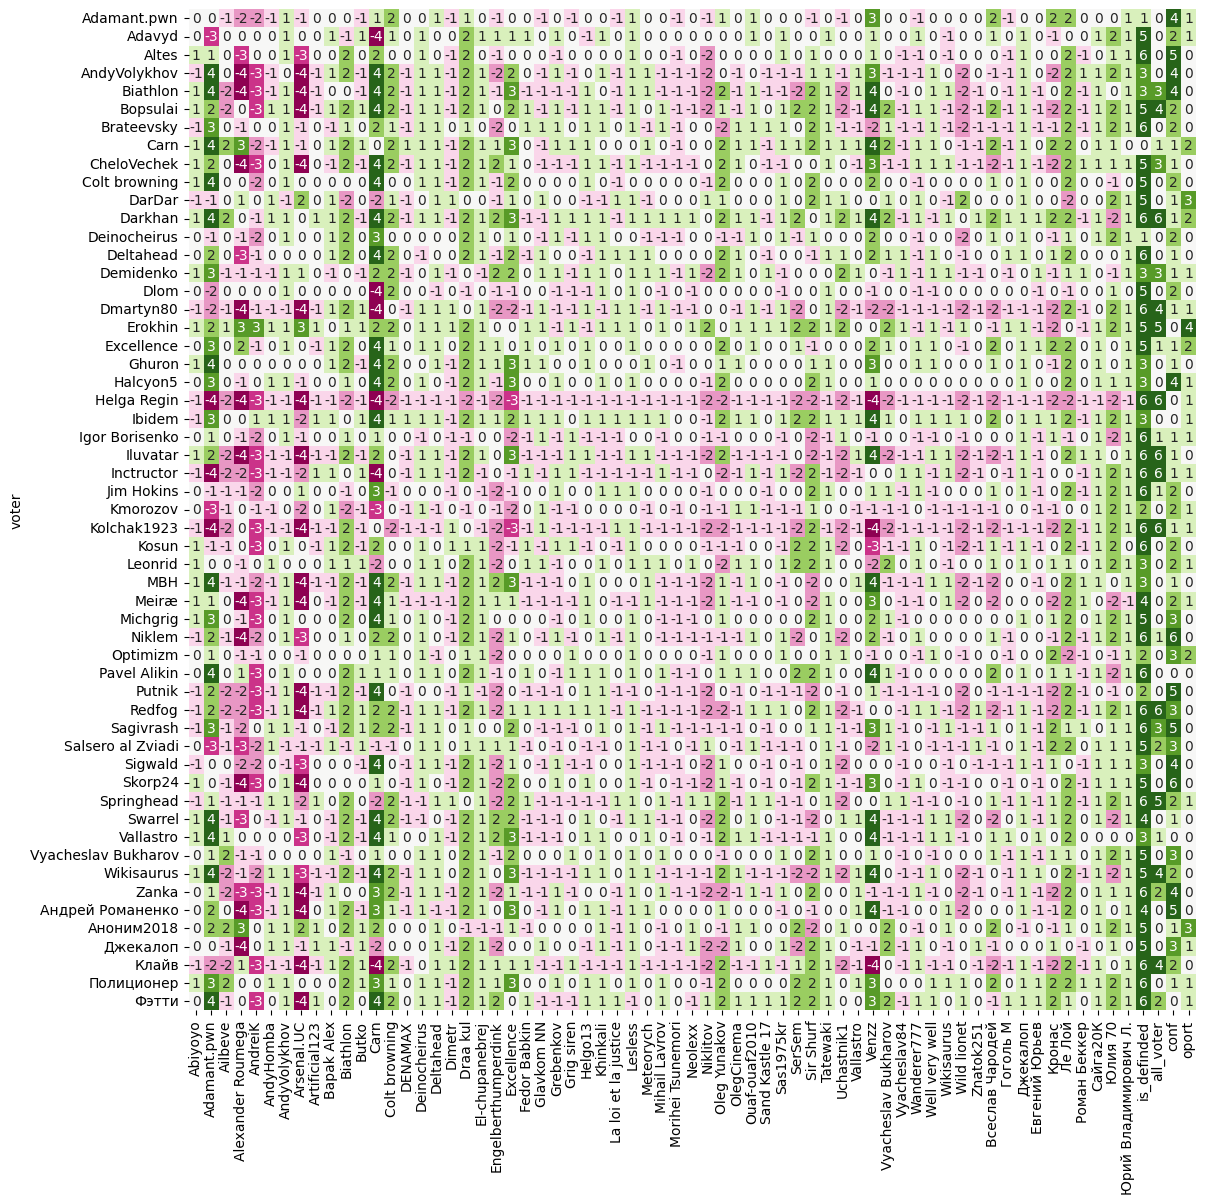

In [175]:
# проведем вычисления
p = pd.DataFrame()
for i in list(df.n.unique()):
    history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values= voters_itog_wiki(i, df)
    tmp = voters_profile_qseg
    p = pd.concat([p, tmp], ignore_index=False, sort=False)




tmp = p[['is_definded', 'all_voter',    'conf', 'oport']]
tmp = tmp.groupby(level=0).sum()
old = df.groupby('voter', as_index = False)['n'].nunique().query('n == 6')['voter']
old = df.query("voter in @old").pivot_table(index= 'voter',columns = ['candidate'],values=['vote'],aggfunc='sum')
old.columns = old.columns.droplevel()
old_profilse =old.merge(tmp,how='inner',on='voter')


plt.figure(figsize=(13,13))
sns.heatmap(old_profilse.fillna(0),cbar=False,annot=True,cmap="PiYG", vmin= -4,vmax=4)
plt.show()

* **На карте можно заметить сохранение определённых электоральных предпочтений у некоторых пользователей: так они относительно стабильно голосовали за одних и против других кандидатов в нескольких выборах, при участии совместном участии последних. Также мы видим что основная часть была определена на протяжении всех выборов. Поведения склонное к конформизму более ярко выраженно у данной группы пользователей**

## Сравнение долей пользователей с определенными электоральными особенностями в группах Kmeans

<Figure size 800x600 with 0 Axes>

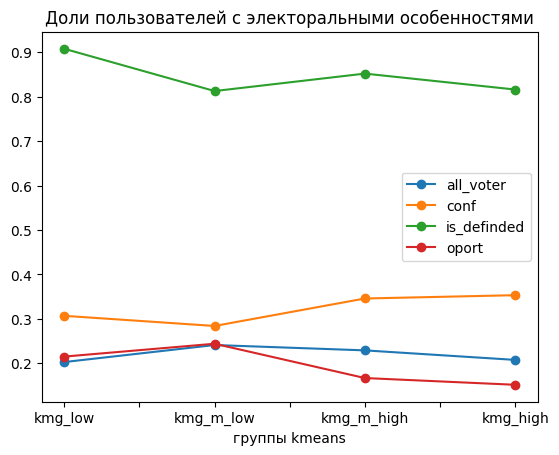

In [176]:
# соберем данные по всем выборам и посчитаем среднюю долю от них
mean_kmg_elect_all = pd.DataFrame()
for k,m in zip(df.n.unique(),range(len(df.n.unique()))):
    history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values  = voters_itog_wiki(k,df)
    mean_kmg_elect = pd.DataFrame()
    for i in ['kmg_low',    'kmg_m_low',    'kmg_m_high',   'kmg_high']:
        tmp = kmg_voters_profile.loc[kmg_voters_profile[i]==1][['is_definded','all_voter','conf','oport']].mean()
        tmp = tmp.to_frame()
        tmp.columns = [i]
        mean_kmg_elect = pd.concat([mean_kmg_elect, tmp],ignore_index=False, sort=False,axis=1)
       
    
    mean_kmg_elect_all = pd.concat([mean_kmg_elect_all, mean_kmg_elect])
    #ax = plt.subplot(2,3,m+1)
    #mean_kmg_elect.T.plot(figsize=(15,10),ax=ax,title=k,marker='.')


# построим график
plt.figure(figsize=(8,6))
mean_kmg_elect_all.groupby(level=0).mean().T.plot(marker='o')
plt.title('Доли пользователей с электоральными особенностями')
plt.xlabel('группы kmeans')
plt.show()

* **На графике можно заметить тенденцию на снижение доли определившихся от младшей к старшей группе kmeans. Также в группе kmg_m_low мы видим максимальное синхронное сближение долей конформистов и оппортунистов при снижении конформистов и увеличении оппортунистов, тогда как в группе kmg_high 
 максимальное расхождение с увеличение конформистов. Уровень конформистов во всех группах выше. Существенных различий в доле людей отдающих все возможные голоса не наблюдается**

## Анализ тенденций изменения долей пользователей с определенными особенностями электорального поведения  в сегментах по квартилям от меньшего значения целевого показателя к большему   

In [177]:
# выделим данные по всем выборам
aldin = pd.DataFrame()
for k in voters_profile_qseg.columns[:9]:
  din = pd.DataFrame()
  for i in list(df.n.unique()):
      history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values  = voters_itog_wiki(i,df)
      
      tmp = voters_profile_qseg.groupby(by=k)[['is_definded','all_voter','conf','oport']].mean()

      din = pd.concat([din, tmp], ignore_index=False, sort=False,axis=1)
  din = din.T.groupby(level=0).mean()
  din = pd.concat([din], keys=[k], names=['q_seg'])
  tmp = din
  aldin = pd.concat([aldin,tmp])
# проверим
display(aldin.head())

0         1         2         3         4
q_seg                                                                   
logs_seg   all_voter    0.202987  0.236790  0.182564  0.317154  0.183428
           conf         0.303253  0.306294  0.285915  0.301723  0.362173
           is_definded  0.923980  0.884848  0.792029  0.839714  0.818198
           oport        0.231219  0.200479  0.271530  0.158439  0.157187
months_seg all_voter    0.226392  0.225371  0.251548  0.195779  0.205482

In [178]:
# Возмем среднее от двух крайних сегментов
aldin[0] = aldin[[0,1]].mean(axis=1)
aldin[1] = aldin[[3,4]].mean(axis=1)


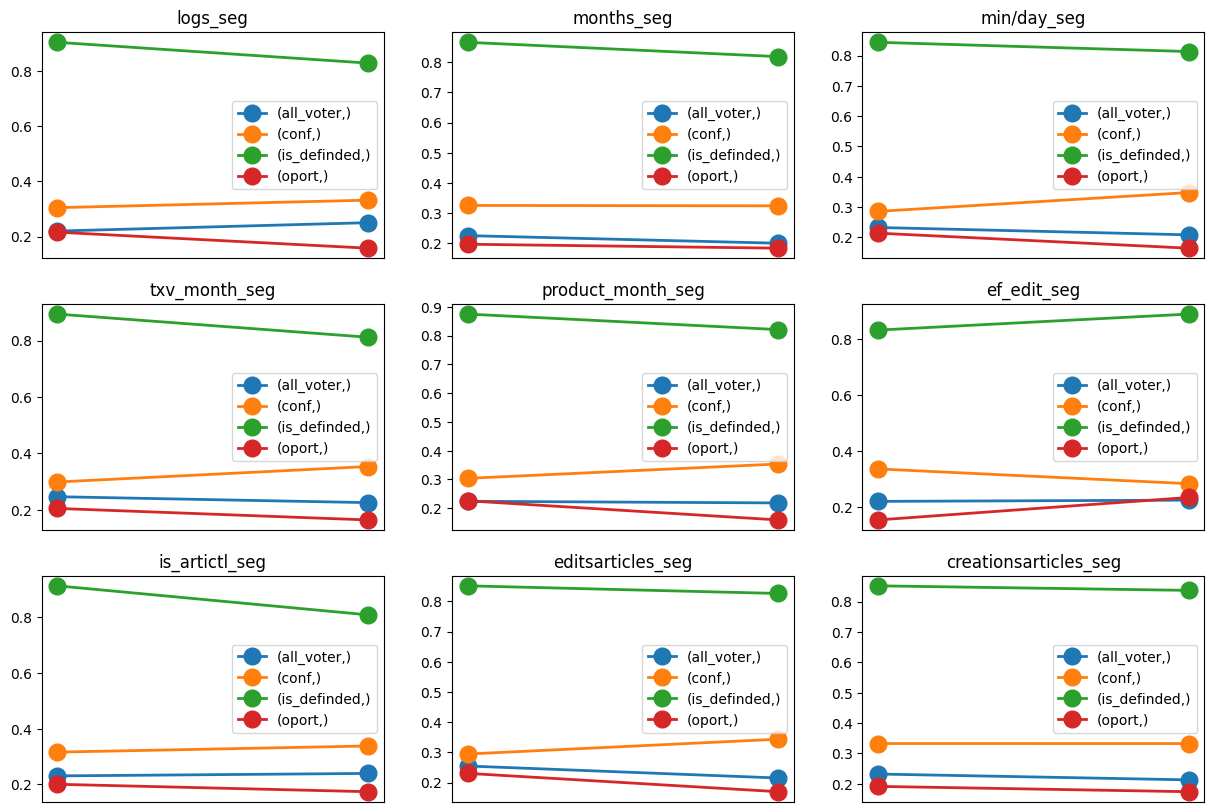

In [179]:
# построим график
s =aldin.reset_index()
for i,k in zip(s.q_seg.unique(),range(9)):
  t = s.loc[s['q_seg']==i][[0,1]]
  t.index = s.loc[s['q_seg']==i][['level_1']]
  ax = plt.subplot(3,3,k+1)
  t.T.plot(figsize=(15,10),ax=ax,title=i,marker='o',markersize = 12,lw=2)
  plt.xticks([])

* **На графике видна тенденция на снижение доли определившихся с увеличение значения всех сегментов кроме сегмента отражающего эффективность правок, что может быть связанно с методикой подсчета в этом сегменте и говорить об обратно пропорциональной связи с остальными метриками, тенденция в сегменте creationarticles_seg по этому показателю не прослеживается. Так же отчетливо видно превышение уровня конформистов над оппортунистами во всех сегментах, причем можно заметить тенденцию на увеличение их доли в min/day_seg, aditsarticle_seg, logs_seg, txt_month_seg, product_month_seg, is_article_seg тогда как по сегментам эффективности наоборот идет снижение конформизма. В сегментах creationarticles_seg и month_seg нет четкой тенденции по показателю конформизма. Доли оппортунистов ведут себя противоположно, то-есть с увеличением конформистов уменьшаются. По долям отдающих все голоса нет четкой динамики.**

# Проведем сравнительный анализ изменений состава голосующих, а также их электорального поведения для каждых выборов

* **Воспользовавшись нашей функцией, построим графики для сравнения всех выборов по качественному составу их участников**

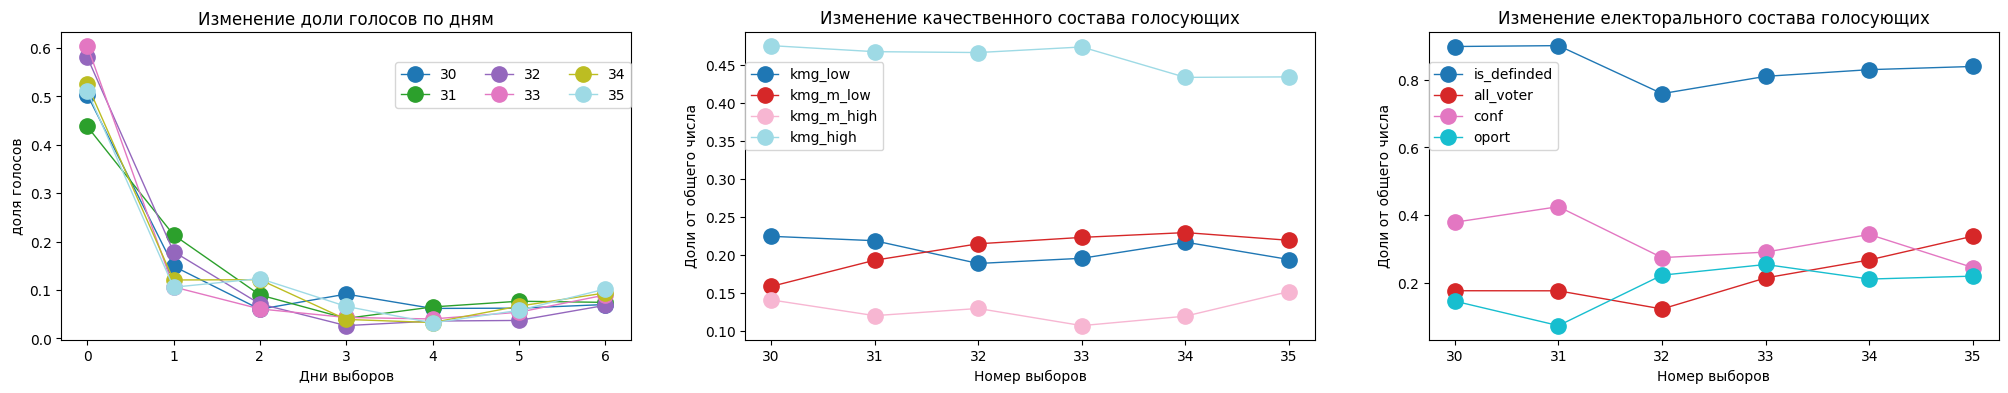

In [180]:

plt.figure(figsize=(25, 4))

# sum_negative_votes by day of every election
ax4 = plt.subplot(1, 3, 1)
din = pd.DataFrame()
for i in list(df.n.unique()):
    history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values   = voters_itog_wiki(i,df)
    tmp = active_vote.reset_index(drop=True)
    tmp.columns = i
    din = pd.concat([din, tmp], ignore_index=True, sort=False,axis=1)

    
din.columns = list(df.n.unique())    
din.plot(linewidth=1,cmap='tab20',marker='.',markersize=22,ax=ax4)

plt.legend(bbox_to_anchor=(0., 0.8, 1., .102), loc='best',
           ncol=3, borderaxespad=0.)
plt.title('Изменение доли голосов по дням')
plt.xlabel('Дни выборов')
plt.yticks(fontsize=10)
plt.ylabel('доля голосов')
plt.yticks(rotation=0)


# Plotting changing the composition of voters
ax2 = plt.subplot(1,3,2)
# didis
v = pd.DataFrame()
for i in list(df.n.unique()):
    history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values   = voters_itog_wiki(i,df)
    tmp = kmg_voters_profile[['kmg_low','kmg_m_low','kmg_m_high','kmg_high']].mean()
    tmp.columns = i
    v = pd.concat([v, tmp], ignore_index=True, sort=False,axis=1)
v.columns = list(df.n.unique())    
v.T.plot(linewidth=1,cmap='tab20',marker='.',markersize=22,ax=ax2)

plt.legend(bbox_to_anchor=(0., 0.8, 1., .102), loc='best',
           ncol=1, borderaxespad=0.,title='')
plt.title('Изменение качественного состава голосующих')
plt.xlabel('Номер выборов')
plt.yticks(fontsize=10)
plt.ylabel('Доли от общего числа')
plt.yticks(rotation=0)

# Plotting changing the composition of voters
ax1 = plt.subplot(1,3,3)
# didis
v = pd.DataFrame()
for i in list(df.n.unique()):
    history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values   = voters_itog_wiki(i,df)
    tmp = kmg_voters_profile[['is_definded','all_voter','conf','oport']].mean()
    tmp.columns = i
    v = pd.concat([v, tmp], ignore_index=True, sort=False,axis=1)
v.columns = list(df.n.unique())    
v.T.plot(linewidth=1,cmap='tab10',marker='.',markersize=22,ax=ax1)

plt.legend(bbox_to_anchor=(0., 0.8, 1., .102), loc='best',
           ncol=1, borderaxespad=0.,title='')
plt.title('Изменение електорального состава голосующих')
plt.xlabel('Номер выборов')
plt.yticks(fontsize=10)
plt.ylabel('Доли от общего числа')
plt.yticks(rotation=0)

plt.show()

* **На графике мы можем заметить относительно однородный состав участников по качественным группам kmeans, однако доли людей с особенностью в электоральном поведении существенно меняются от выборов к выборам. Так после 31 выборов мы видим резкое изменение состава голосующих пользователей по признакам электорального поведения: число конформистов и определившихся резко упало, тогда как оппортунистов наоборот выросло. Долю людей отдающих все голоса в эти выборы была минимальна, после чего начала расти. На графике изменения доли голосов мы можем заметить относительную стабильность: основная часть голосует в первые 2 дня, на 6 и 7 дни небольшое увеличение активности**

### График изменения кумулятивной суммы голосов с результатами победителей

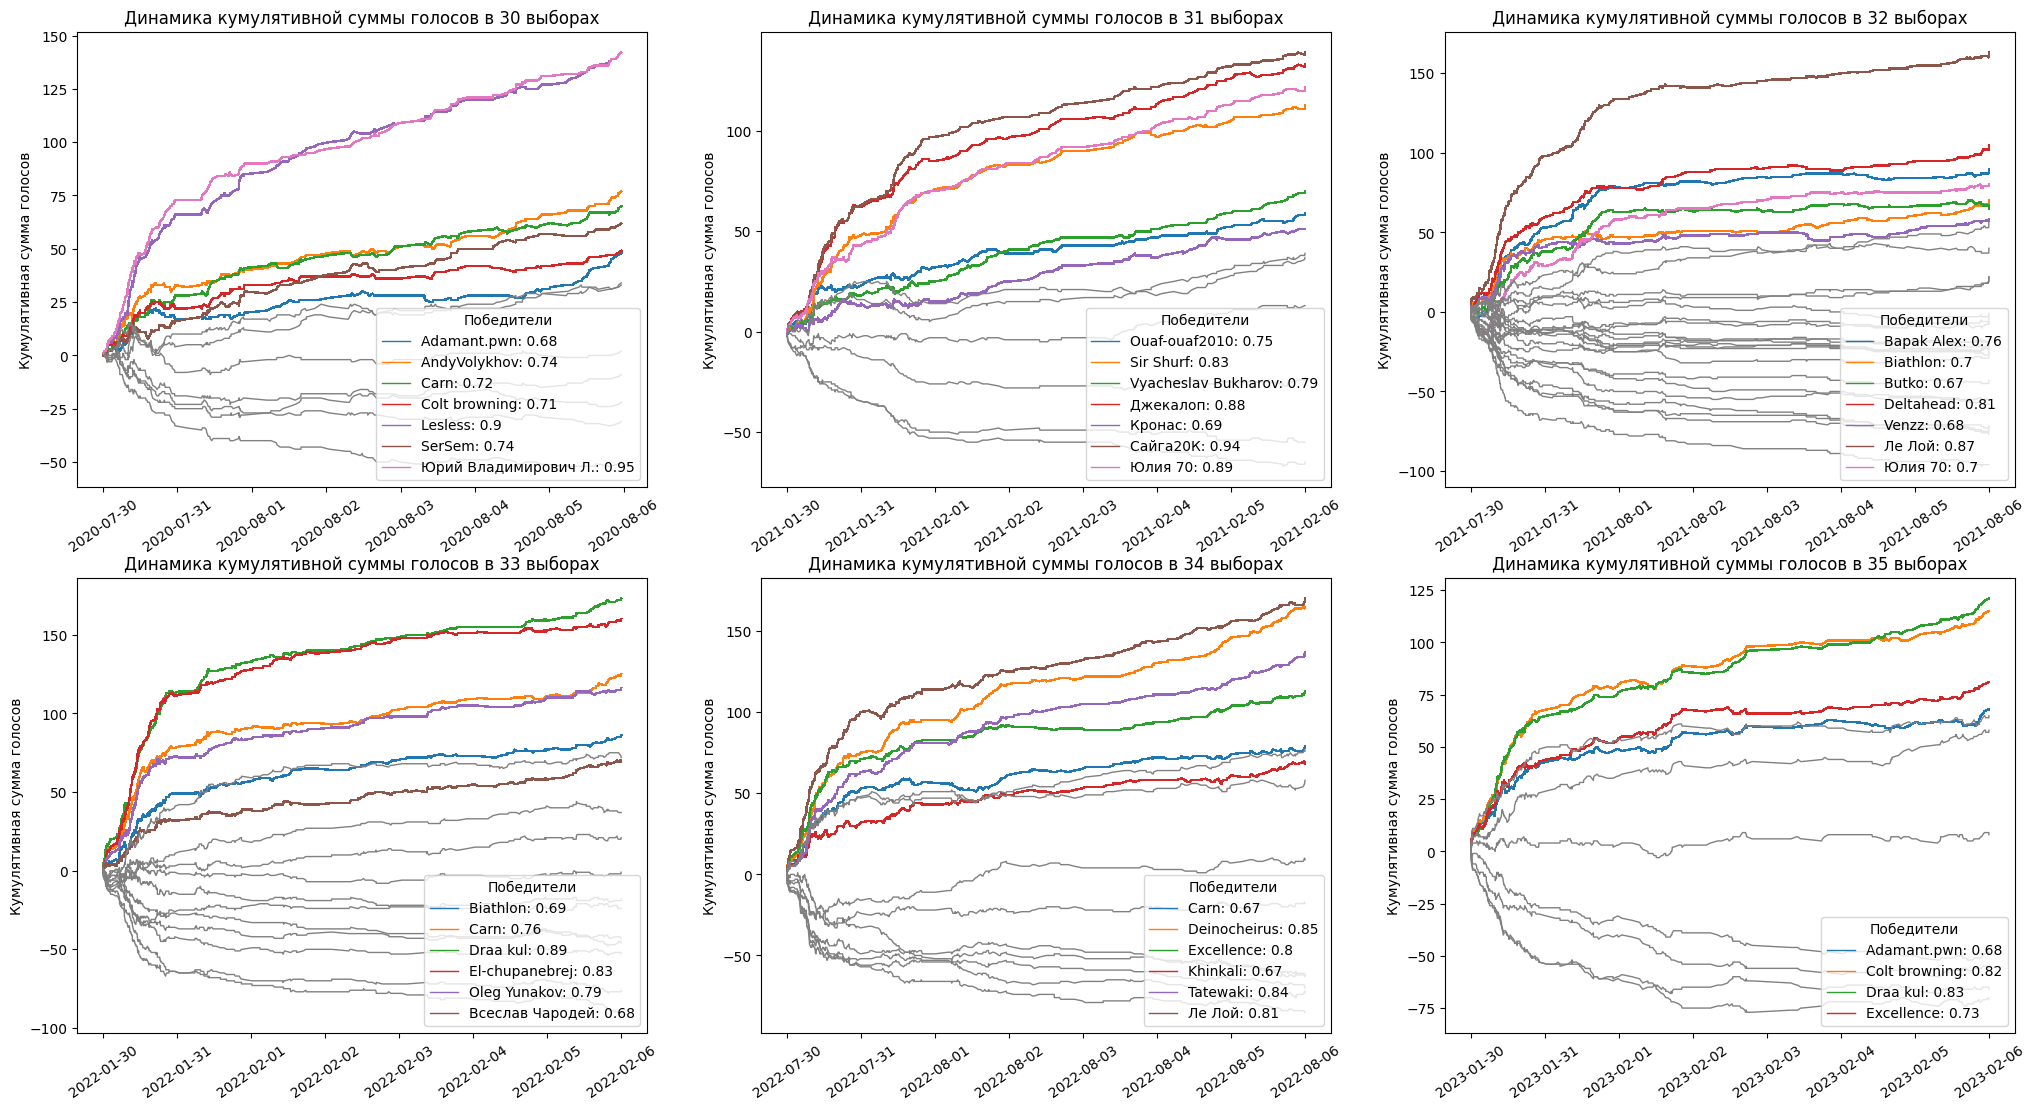

In [181]:
# Plotting history voted
plt.figure(figsize=(25, 13))

for i, k in zip(df.n.unique(),range(len(df.n.unique()))):
    ax = plt.subplot(2,3,k+1)

    history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values  = voters_itog_wiki(i,df)
    plt.plot(
        df.query("n == @i and candidate in @winners.index").pivot_table(index = 'candidate',columns='time',values='vote',aggfunc='sum').fillna(0).cumsum(axis=1).T.fillna(0),
        lw=1,linestyle='-',antialiased=False,mouseover = True
    ) 
    plt.legend(list(winners.index+": "+winners.round(2).astype('str')),title='Победители',loc='lower right')
    plt.plot(
        df.query("n == @i and candidate not in @winners.index").pivot_table(index = 'candidate',columns='time',values='vote',aggfunc='sum').fillna(0).cumsum(axis=1).T,
        lw=1,linestyle='-', color='grey'
    )
    #plt.legend(list(losers.index+": "+losers.round(2).astype('str')),title='Проигравшие')

    plt.title(f'Динамика кумулятивной суммы голосов в {i} выборах')
    plt.xlabel('')
    plt.ylabel('Кумулятивная сумма голосов')
    #plt.yticks([])
    #plt.xticks([])
    plt.xticks(rotation=35)

plt.show()

* **На графике видно, что максимально активное голосование проходит в первый день на всех выборах, так же можно заметить некоторую ступенчатость графиков, что можно объяснить синхронным голосованием некоторых пользователей. Еще можно отметить самое большое число кандидатов в 32 выборах**

### График изменение результата кандидатов

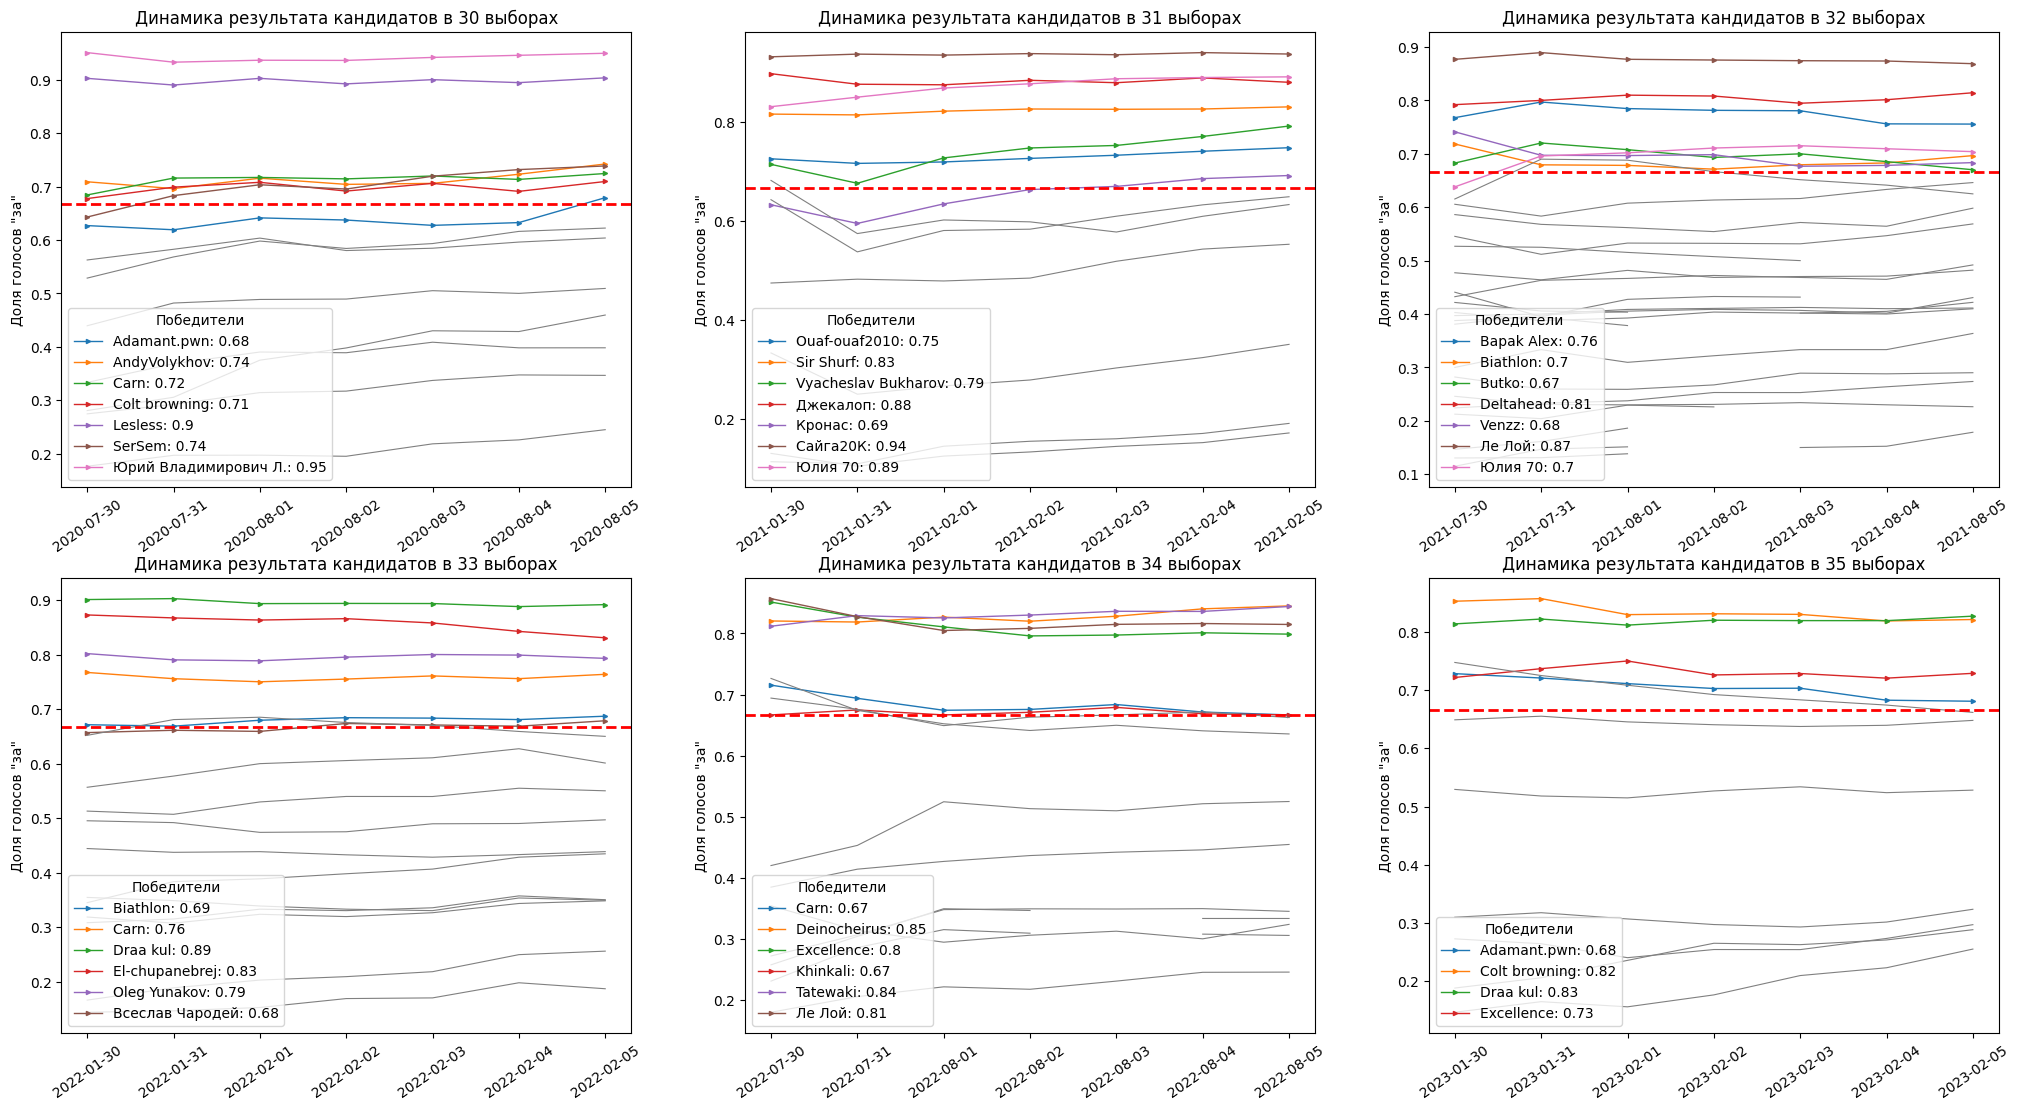

In [182]:
# Plotting history voted
plt.figure(figsize=(25, 13))

for i, k in zip(df.n.unique(),range(len(df.n.unique()))):
    ax = plt.subplot(2,3,k+1)

    history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values  = voters_itog_wiki(i,df)
    plt.plot(
        history.query("candidate in @winners.index").T,
        lw=1, marker='>',linestyle='-',markersize=3
    ) 
    plt.legend(list(winners.index+": "+winners.round(2).astype('str')),title='Победители',loc='lower left')
    plt.plot(
        history.query("candidate not in @winners.index").T,
        lw=0.8,linestyle='-', color='grey'
    )
    #plt.legend(list(losers.index+": "+losers.round(2).astype('str')),title='Проигравшие')

    plt.title(f'Динамика результата кандидатов в {i} выборах')
    plt.xlabel('')
    #plt.yticks([])
    #plt.xticks([])
    plt.ylabel('Доля голосов "за"')
    plt.xticks(rotation=35)
    plt.axhline(y=0.6666, color='red', linestyle='--', label='Уровень победы',linewidth=2)
plt.show()

* **Мы можем заметить что во всех выборах победители в основном определяются в первый день голосования и далее их результат меняется лишь незначительно. Однако в редких случаях кандидаты могут как потерять так получить лидерство и не в первый день**

# Вывод по итогам анализа эдекторального поведения пользователей 

* **В целом участники голосования больше склонны к конформизму**
* **Существенных различий в уровне конформизма нет между кандидатами, голосующими и общей выборкой**
* **По результатам теста ANOVA мы можем говорть о наличии значимых различий уровня конформизма среди kmeans групп**
* **По результатам т теста мы увидели статистически значимые различия в уровне конформизма в кластерах kmg_m_low и kmg_high в  меньшую и большую сторону относительно общей выборки соответственно**
* **Можно заметить что основная часть голосующих принимает участие в одних выборах, далее с возрастание количества участий количество голосующих линейно снижается, однако 6 раз выборах приняли участие больше людей чем в 5**
* **Пользователи, принявшие участие в 6 выборах, имеют статистически значимый уровень отличия конформизме от общей выборки, причем это отличие в большей склонности к конформизму**
* **Можно заметить сохранение определённых электоральных предпочтений у некоторых пользователей: так они относительно стабильно голосовали за одних и против других кандидатов в нескольких выборах, при участии совместном участии последних. Также мы видим что основная часть была определена на протяжении всех выборов. Поведение склонное к конформизму более ярко выраженно у данной группы пользователей**
* **Можно заметить тенденцию на снижение доли определившихся от младшей к старшей группе kmeans. Также в группе kmg_m_low мы видим максимальное синхронное сближение долей конформистов и оппортунистов при снижении конформистов и увеличении оппортунистов, тогда как в группе kmg_high максимальное расхождение с увеличение конформистов. Уровень конформистов во всех группах выше. Существенных различий в доле людей отдающих все возможные голоса не наблюдается**
* **Прослеживается тенденция на снижение доли определившихся с увеличение значения всех сегментов кроме сегмента отражающего эффективность правок, что может быть связанно с методикой подсчета в этом сегменте и говорить об обратно пропорциональной связью с остальными метриками, тенденция в сегменте creationarticles_seg по этому показателю не прослеживается. Так же отчетливо видно превышение уровня конформистов над оппортунистами во всех сегментах, причем можно заметить тенденцию на увеличение их доли в min/day_seg, aditsarticle_seg, logs_seg, txt_month_seg, product_month_seg, is_article_seg тогда как по сегментам эффективности наоборот идет снижение конформизма. В сегментах creationarticles_seg и month_seg нет четкой тенденции по показателю конформизма. Доли оппортунистов ведут себя противоположно, то-есть с увеличением конформистов уменьшаются. По долям отдающих все голоса нет четкой динамики.**
* **Мы можем заметить относительно однородный состав участников по качественным группам kmeans, однако доли людей с особенностью в электоральном поведении существенно меняются от выборов к выборам. Так после 31 выборов мы видим резкое изменение состава голосующих пользователей по признакам электорального поведения: число конформистов и определившихся резко упало, тогда как оппортунистов наоборот выросло. Долю людей отдающих все голоса в эти выборы была минимальна, после чего начала расти. На графике изменения доли голосов мы можем заметить относительную стабильность: основная часть голосует в первые 2 дня, на 6 и 7 дни небольшое увеличение активности**
* **Максимально активное голосование проходит в первый день на всех выборах, так же можно заметить некоторую ступенчатость графиков, что можно объяснить синхронным голосованием некоторых пользователей. Еще можно отметить самое большое число кандидатов в 32 выборах**
* **Мы можем заметить что во всех выборах победители в основном определяются в первый день голосования и далее их результат меняется лишь незначительно. Однако в редких случаях кандидаты могут как потерять так получить лидерство и не в первый день**

* **По совокупности наблюдений сравнительного анализа выборов можно предположить о некотором изменении в электоральном поведения пользователей после 32 выборов, что дает повод провести подробный их анализ**


## Кластерный анализ методом KMeans электорального поведения голосующих на 32 выборах 

* **Для этого составим таблицу которая характеризует электоральное поведение каждого пользователя**

In [183]:
# применим функцию 
history, result, winners, active_vote, losers, kmg_voters_profile, voters_profile_qseg, vot_cand, conferm_values  = voters_itog_wiki(32,df)


In [184]:
# добавим информацию о голосавании 
al = pd.concat([voters_profile_qseg,vot_cand],ignore_index=False,sort=False,join ='inner',axis=1)
al =al[al.columns[9:]]

display(al.head())
print(f"Принимало участие в выборах: {len(al.index)}")

is_definded  all_voter  conf  oport  Abiyoyo  \
voter                                                                
CheloVechek                     1          0     0      0      1.0   
Олег07                          1          0     0      0     -1.0   
Brateevsky                      1          0     1      0     -1.0   
Юрий Владимирович Л.            1          0     0      1      1.0   
Dmartyn80                       1          0     1      0     -1.0   

                      Adamant.pwn  Ailbeve  Alexander Roumega  AndyHomba  \
voter                                                                      
CheloVechek                  -1.0      1.0               -1.0        0.0   
Олег07                       -1.0      0.0                1.0        1.0   
Brateevsky                    0.0      1.0               -1.0        0.0   
Юрий Владимирович Л.          1.0      0.0                0.0        1.0   
Dmartyn80                    -1.0      0.0               -1.0       -1.0   

                      Arsenal.UC  ...  Venzz  Vyacheslav Bukharov  Wikisaurus  \
voter                             ...                                           
CheloVechek                 -1.0  ...    0.0                 -1.0         1.0   
Олег07                       1.0  ...    1.0                 -1.0        -1.0   
Brateevsky                  -1.0  ...    1.0                  0.0        -1.0   
Юрий Владимирович Л.         0.0  ...    1.0                  0.0         1.0   
Dmartyn80                   -1.0  ...    1.0                 -1.0        -1.0   

                      Wild lionet  Znatok251  Всеслав Чародей  Кронас  Ле Лой  \
voter                                                                           
CheloVechek                  -1.0       -1.0             -1.0    -1.0     1.0   
Олег07                       -1.0       -1.0             -1.0    -1.0     0.0   
Brateevsky                   -1.0       -1.0              0.0    -1.0     1.0   
Юрий Владимирович Л.          0.0        0.0              1.0     1.0     1.0   
Dmartyn80                    -1.0       -1.0             -1.0    -1.0     1.0   

                      Роман Беккер  Юлия 70  
voter                                        
CheloVechek                    1.0      0.0  
Олег07                        -1.0     -1.0  
Brateevsky                    -1.0      1.0  
Юрий Владимирович Л.           0.0      1.0  
Dmartyn80                     -1.0      1.0  

[5 rows x 32 columns]

Принимало участие в выборах: 270


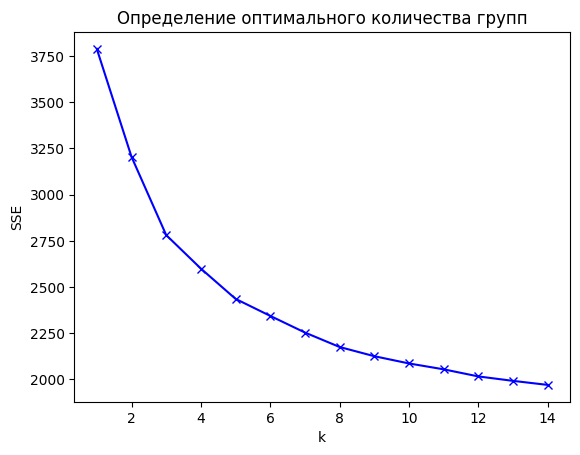

In [185]:
# подберем оптимальное значение групп
Sum_of_squared_distances =[]
K = range(1,15)
for k in K:
    km =KMeans(n_clusters =k)
    km =km.fit(al)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Определение оптимального количества групп')
plt.show()

In [186]:
# в нашем случае 3 группы, обучим модель
kmeans = KMeans(n_clusters=3).fit(al)

In [187]:
# сформируем ряд цвета групп 
row_colors =  pd.DataFrame( kmeans.labels_ )
row_colors['kmeans_group'] = kmeans.labels_

lut1 = dict(zip(set(kmeans.labels_), ['#ED2323','#000000','#155000']))
row_colors = row_colors['kmeans_group'].map(lut1)
row_colors.index = al.index
row_colors.head()

voter
CheloVechek             #ED2323
Олег07                  #000000
Brateevsky              #000000
Юрий Владимирович Л.    #155000
Dmartyn80               #000000
Name: kmeans_group, dtype: object

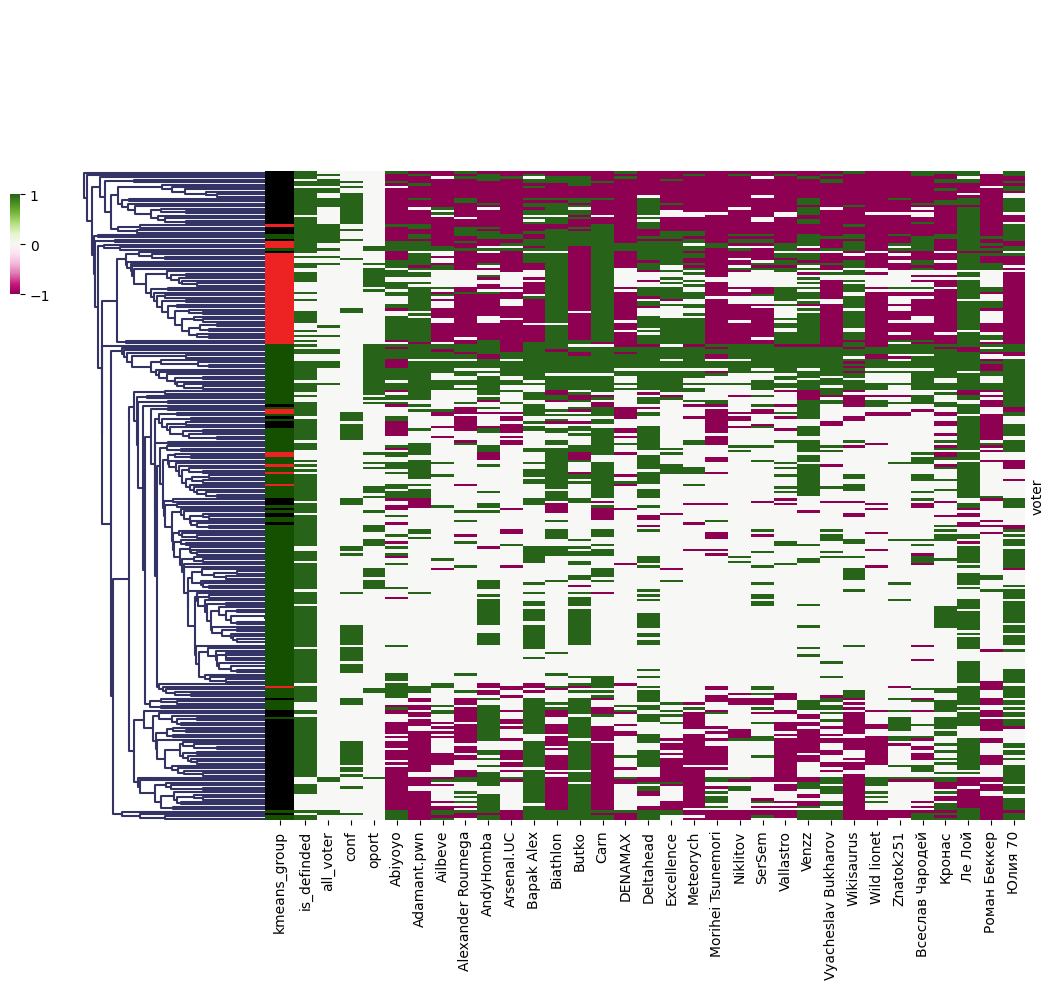

In [188]:
# построим график
h = sns.clustermap(al,annot=False,cbar_pos=(-0.05, .7, .01, .1), yticklabels=False, xticklabels=True,figsize=(10,10),tree_kws=dict(linewidths=1.5, colors=(0.2, 0.2, 0.4)),lw=0.0,
                   row_colors= row_colors,col_cluster=False,cmap="PiYG",vmin=-1, vmax=1)

plt.show()

* **После кластерного анализа мы определили 3 группы пользователей с разным предпочтением в голосовании и особенностями электорального поведения**

In [189]:
# добавим значение групп
voters_profile_qseg['kmeans_group'] = kmeans.labels_

* **Проведем вычисления и посмотрим на доли людей с особенностями в электоральном поведении этих групп**

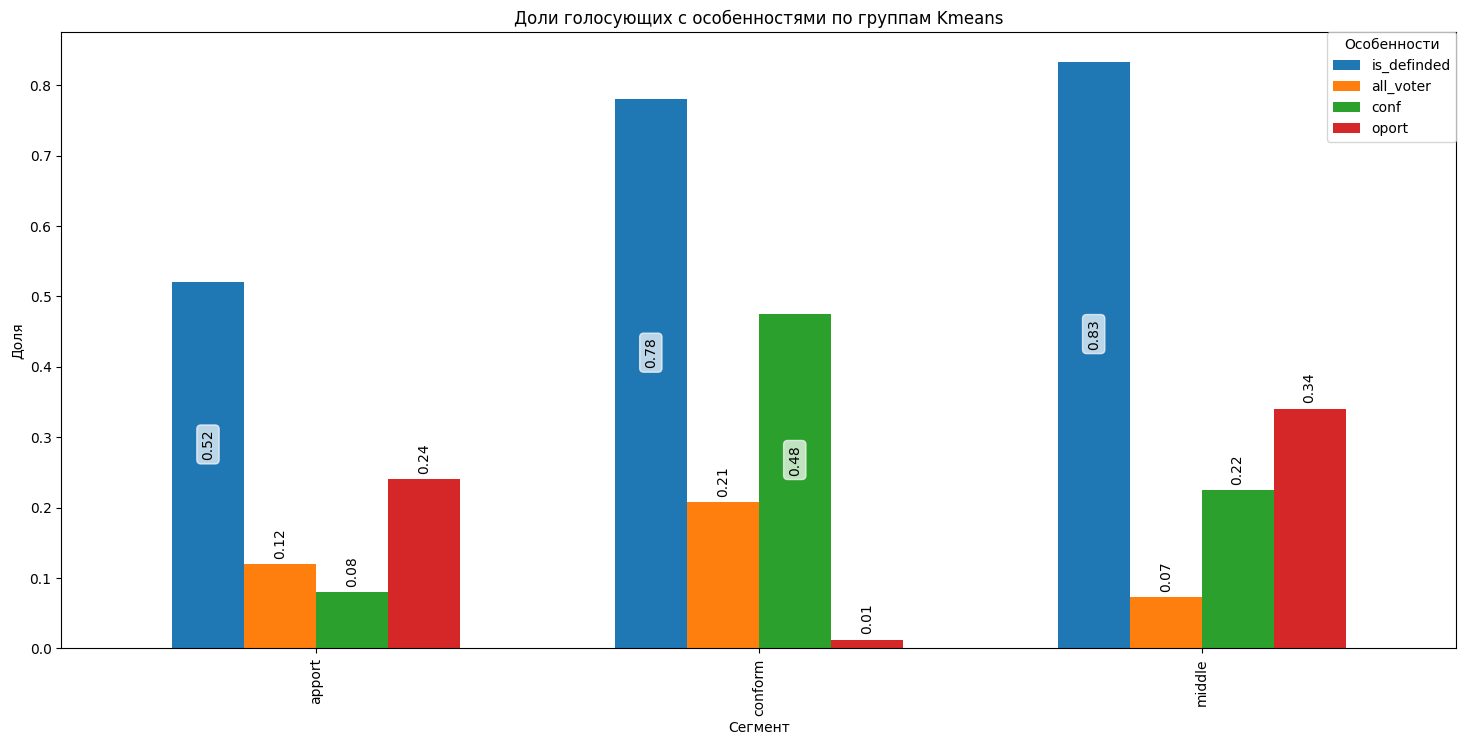

In [193]:
# построим график
ax=voters_profile_qseg.groupby(by="kmeans_group")[voters_profile_qseg.columns[9:13]].mean().plot(kind="bar",figsize=(18,8),width=0.65)
plt.legend( loc='best',
           ncol=1, borderaxespad=0.,title='Особенности')
add_value_labels(ax,'bar', space=4,fmt='{:,.2f}')
plt.title('Доли голосующих с особенностями по группам Kmeans')
plt.xlabel('Сегмент')
plt.yticks(fontsize=10)
plt.ylabel('Доля')
plt.yticks(rotation=0)

plt.show()

* **Можно заметить довольно существенное различие по долям конформистов и оппортунистов в этих группах**

* **Проведем вычисления и дадим названия группам согласно долям конформистов в них**

In [191]:
# проведем вычисления и дадим названия
tmp = voters_profile_qseg.groupby(by="kmeans_group")["conf"].mean().sort_values()
tmp.to_frame().index
tmp = dict(zip(tmp.index,["apport","middle","conform"]))
voters_profile_qseg['kmeans_group'] = voters_profile_qseg["kmeans_group"].map(tmp)
voters_profile_qseg['kmeans_group'].unique()

array(['apport', 'conform', 'middle'], dtype=object)

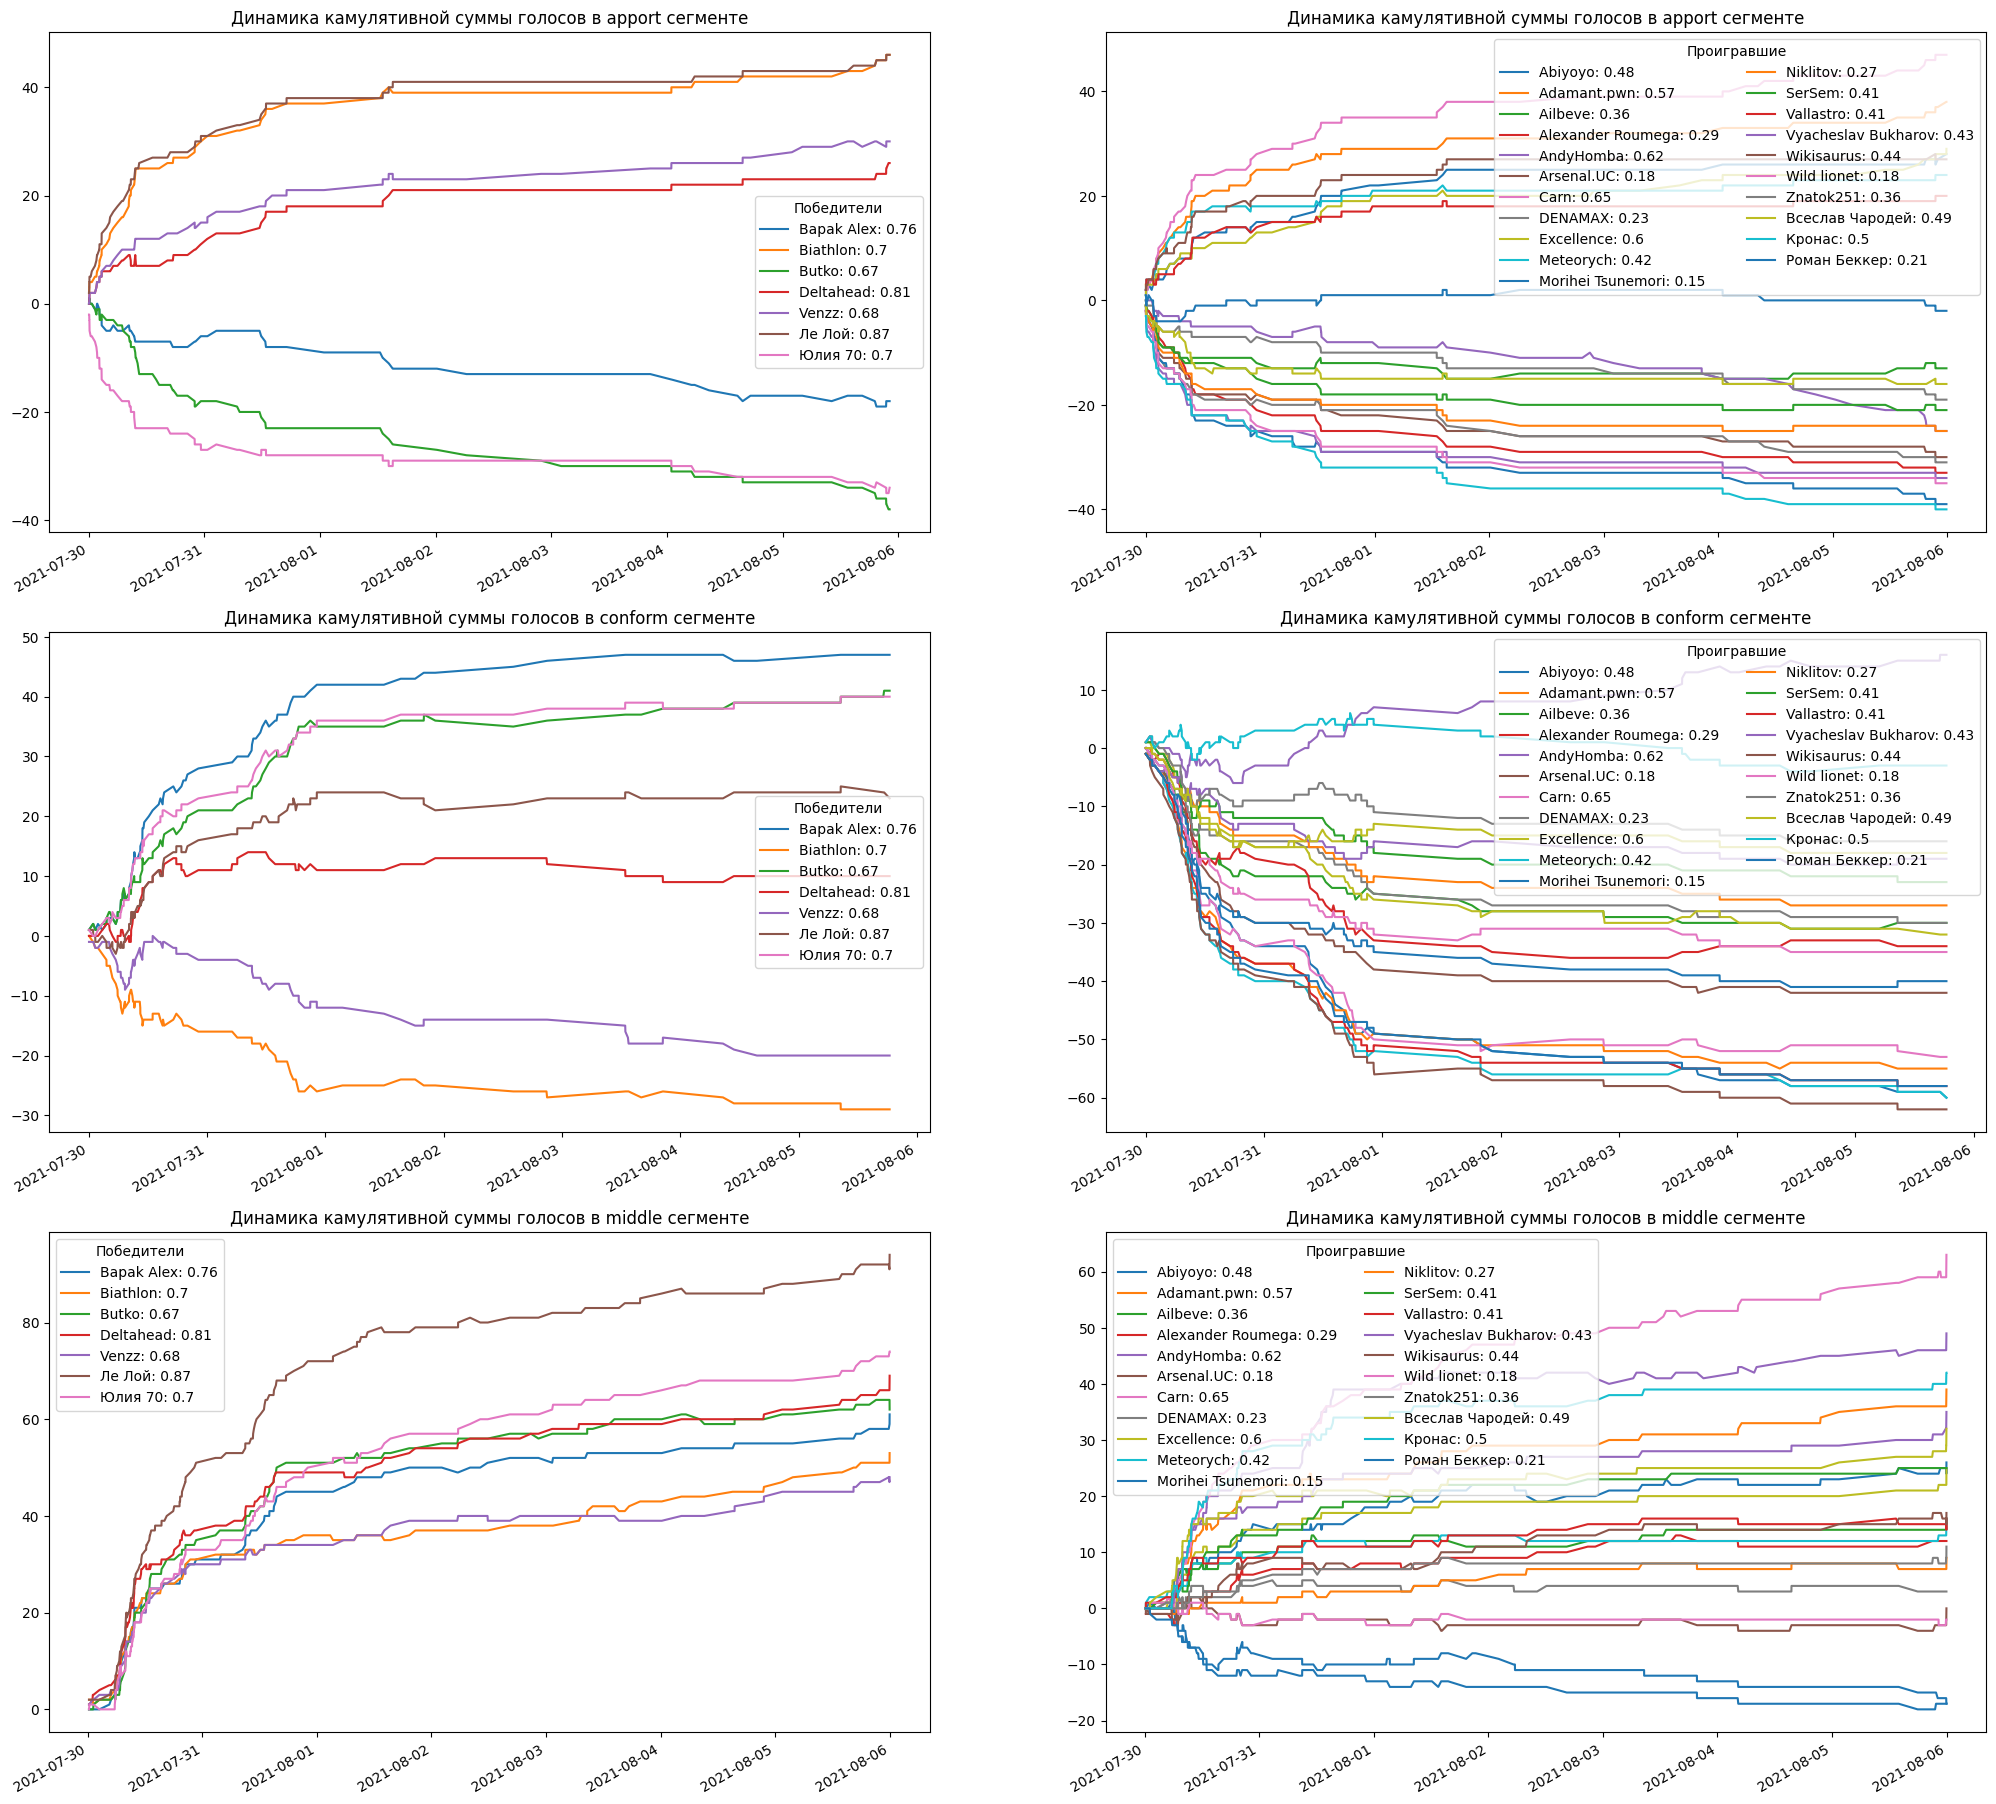

In [192]:
# построим график 
plt.figure(figsize=(25,25)) 
for i,k in zip(range(3),voters_profile_qseg['kmeans_group'].unique()):
    
    ax = plt.subplot(3,2,i+i+1)
    zero_g = voters_profile_qseg.query("kmeans_group == @k").index
    df.query("voter in @zero_g and n ==32 and candidate  in @winners.index").pivot_table(index='time',columns = 'candidate',values='vote',aggfunc='sum').fillna(0).cumsum().plot(title=('Динамика камулятивной суммы голосов в '+str(k)+" сегменте") ,ax=ax)
    plt.legend(list(winners.index+": "+winners.round(2).astype('str')),title='Победители', )
    plt.xlabel('')
    plt.ylabel('')

    
    ax = plt.subplot(3,2,i+i+2)
    zero_g =  voters_profile_qseg.query("kmeans_group == @k").index
    df.query("voter in @zero_g and n ==32 and candidate  in @losers.index").pivot_table(index='time',columns = 'candidate',values='vote',aggfunc='sum').fillna(0).cumsum().plot(ax=ax, title=('Динамика камулятивной суммы голосов в '+str(k)+" сегменте"))
    plt.legend(list(losers.index+": "+losers.round(2).astype('str')),title='Проигравшие', ncol=2)
    plt.xlabel('')
    plt.ylabel('')
plt.show()

* **На графике можно заметить что в сегменте apport и conform довольно синхронное голосование которое видно по ступеням на графиках. Причем наблюдается голосование против и за определенных кандидатов-победителей в одни моменты времени на протяжении всего хода голосования**

# Общий вывод по результатам исследования:
* **В голосовании принимают участие более актиные пользователи в целом**
* **Актавность кандидатов значительно выше голосующих пользователей**
* **В целом голосующие пользователи больше склонны к нонформизму**
* **Кандидаты не отличаются по уровню конформизма от голосующих**
* **С увеличением активности падает доля определившихся пользователей**
* **В целом выявленна некоторая зависимость уровня конформизма от уровня активности пользователей, но в разных выдах активности она выраженна в разной степени**
* **После 32 выборов наблюдается резкое изменение общей модели электорального поведения пользователей**